# Import Libraries

In [11]:
from AirlineDataPreparation import *

import pandas as pd
import numpy as np

import datetime as dt
import re
from collections import Counter
import gc
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set()

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

sns.set(font_scale = 2)

#plt.style.use('fivethirtyeight') # pretty matplotlib plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

from imblearn.over_sampling import RandomOverSampler

from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, fbeta_score

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Helper Functions

In [4]:
# Function to compute the memory usage of a dataframe
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [5]:
# Make twin axis
def make_twin_axis(ax, ncount, maxfreq=100):
    
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right');
    ax2.yaxis.set_label_position('left');

    ax2.set_ylabel('Frequency [%]');

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,maxfreq);
    ax.set_ylim(0,ncount/(100/maxfreq));
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(10))
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(maxfreq/10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None);
    # Annotate the bars
    for p in ax.patches:
        x_bar=p.get_bbox().get_points()[:,0]
        y_bar=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}'.format(100.*y_bar/ncount), (x_bar.mean(), y_bar), 
                    ha='center', va='bottom') # set the alignment of the text

# Get Supplemental Data

In [5]:
# Major Airports
file_name = 'data/MajorAirports.csv'
airports_df = pd.read_csv(file_name)

# Major Airlines
file_name = 'data/MajorCarriers.csv'
carriers_df = pd.read_csv(file_name)

# Holidays
file_name = 'data/Holidays2017.csv'
holidays_df = pd.read_csv(file_name)

date_fmt = '%m/%d/%Y'
holidays_df['Start Date'] = pd.to_datetime(holidays_df['Start Date'], format= date_fmt)
holidays_df['End Date']   = pd.to_datetime(holidays_df['End Date'],   format= date_fmt)

holidays = []
for start, end in zip(holidays_df['Start Date'], holidays_df['End Date']):
    holidays.extend(pd.date_range(start, end).date)
    
del holidays_df
gc.collect();

# Read Data, Clean and Create Dataframe

In [6]:
# Valid columns in CSV files
valid_cols = [ 'FL_DATE', 'UNIQUE_CARRIER', 'TAIL_NUM', 'FL_NUM', 'ORIGIN_AIRPORT_ID',
               'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'CRS_DEP_TIME', 'DEP_DELAY',
               'DEP_DELAY_GROUP', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_GROUP',
               'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'DISTANCE',
               'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
               'LATE_AIRCRAFT_DELAY']

## Define features and target set
# Airport based features
features = ['ORIGIN', 'DEST', 'ORIG_REGION', 'DEST_REGION', 
            'INTER_ARR_TIME', 'LOG_INTER_ARR_TIME']
# Airline based features
features.extend(['UNIQUE_CARRIER', 'FL_NUM'])
# Flight based features
features.extend(['DISTANCE', 'DISTANCE_BIN', 
                 'DURATION_BIN', 'DEP_DELAY_GROUP'])
dep_delay_arr = []
for thresh in np.arange(0,20,5):
    dep_delay_arr.append('IS_DELAYED_DEP_' + str(thresh))
features.extend(dep_delay_arr)

# time based feature
features.extend(['HOLIDAY', 'DAY_OF_WEEK', 
                 'DEP_HOUR', 'ARR_HOUR', 
                 'DEP_TIME_BIN', 'ARR_TIME_BIN',
                 'SEASON', 'MONTH'])
#target
target = []
for thresh in np.arange(0,20,5):
    target.append('IS_DELAYED_ARR_' + str(thresh))

#extra
extra = ['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ARR_DELAY_GROUP']

In [7]:
print('Target:', target)
print('\nFeatures:', features)
print('\nExtra:', extra)

Target: ['IS_DELAYED_ARR_0', 'IS_DELAYED_ARR_5', 'IS_DELAYED_ARR_10', 'IS_DELAYED_ARR_15']

Features: ['ORIGIN', 'DEST', 'ORIG_REGION', 'DEST_REGION', 'INTER_ARR_TIME', 'LOG_INTER_ARR_TIME', 'UNIQUE_CARRIER', 'FL_NUM', 'DISTANCE', 'DISTANCE_BIN', 'DURATION_BIN', 'DEP_DELAY_GROUP', 'IS_DELAYED_DEP_0', 'IS_DELAYED_DEP_5', 'IS_DELAYED_DEP_10', 'IS_DELAYED_DEP_15', 'HOLIDAY', 'DAY_OF_WEEK', 'DEP_HOUR', 'ARR_HOUR', 'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'MONTH']

Extra: ['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ARR_DELAY_GROUP']


In [8]:
year = '2017'
num_months = 12

# get the on time data for year
data_folder = 'data/FLIGHT_ONTIME_'
ontime_list = []
for num in range(1,num_months+1):
    month = "{0:0=2d}".format(num)
    filename = data_folder+month+year +'.csv'   
    
    df = pd.read_csv(filename)
    print('Cleaning {}...'.format(filename))
    
    clean_df = create_clean_df(df, airports_df, carriers_df, 
                               holidays, 
                               features, target, extra,
                               valid_cols, 
                               verbose=True)
    ontime_list.append(clean_df)
    
# concatenate all the dataframes
ontime_df = pd.concat(ontime_list, ignore_index=True)

# delete list not needed
del ontime_list[:] 
del df
del clean_df
gc.collect()

Cleaning data/FLIGHT_ONTIME_012017.csv...
	Converting to datetime objects...
	Deleting junk columns...
	Deleting...
	Cancelled flights = 8886
	Diverted flights = 1486
	Number of airports in original data = 297
	Number of airports in filtered data = 30
	Number of carriers in original data = 11
	Number of carriers in filtered data = 8
	Checking for NULL values...
	Creating target columns...
	Creating Flight features...
	Creating Airport features...
	Creating Time-based features...
	Creating new dataframe...
	Changing datatypes...
Cleaning data/FLIGHT_ONTIME_022017.csv...
	Converting to datetime objects...
	Deleting junk columns...
	Deleting...
	Cancelled flights = 6312
	Diverted flights = 980
	Number of airports in original data = 296
	Number of airports in filtered data = 30
	Number of carriers in original data = 11
	Number of carriers in filtered data = 8
	Checking for NULL values...
	Creating target columns...
	Creating Flight features...
	Creating Airport features...
	Creating Time-b

1603

In [9]:
# Convert SEASON and MONTH to categorical variables 
ontime_df['SEASON'] = ontime_df['SEASON'].astype('category')
ontime_df['MONTH']  = ontime_df['MONTH'].astype('category')

# Convert DEP_HOUR and ARR_HOUR to categorical variables 
ontime_df['DEP_HOUR'] = ontime_df['DEP_HOUR'].astype('category')
ontime_df['ARR_HOUR'] = ontime_df['ARR_HOUR'].astype('category')

ontime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151813 entries, 0 to 2151812
Data columns (total 32 columns):
ORIGIN                category
DEST                  category
ORIG_REGION           category
DEST_REGION           category
INTER_ARR_TIME        float32
LOG_INTER_ARR_TIME    float32
UNIQUE_CARRIER        category
FL_NUM                uint16
DISTANCE              float32
DISTANCE_BIN          category
DURATION_BIN          category
DEP_DELAY_GROUP       category
IS_DELAYED_DEP_0      bool
IS_DELAYED_DEP_5      bool
IS_DELAYED_DEP_10     bool
IS_DELAYED_DEP_15     bool
HOLIDAY               bool
DAY_OF_WEEK           category
DEP_HOUR              category
ARR_HOUR              category
DEP_TIME_BIN          category
ARR_TIME_BIN          category
SEASON                category
MONTH                 category
IS_DELAYED_ARR_0      bool
IS_DELAYED_ARR_5      bool
IS_DELAYED_ARR_10     bool
IS_DELAYED_ARR_15     bool
FL_DATE               datetime64[ns]
DEP_DELAY             f

In [10]:
ontime_df.head()

,ORIGIN,DEST,ORIG_REGION,DEST_REGION,INTER_ARR_TIME,LOG_INTER_ARR_TIME,UNIQUE_CARRIER,FL_NUM,DISTANCE,DISTANCE_BIN,...,SEASON,MONTH,IS_DELAYED_ARR_0,IS_DELAYED_ARR_5,IS_DELAYED_ARR_10,IS_DELAYED_ARR_15,FL_DATE,DEP_DELAY,ARR_DELAY,ARR_DELAY_GROUP
0,DEN,ATL,Central,South,0.0,-5.000000,WN,163,1199.0,2,...,Winter,Jan,False,False,False,False,2017-01-01,12.0,-8.0,-1.0
1,LAS,ATL,West,South,220.0,5.393628,F9,1456,1747.0,2,...,Winter,Jan,False,False,False,False,2017-01-01,-4.0,-15.0,-1.0
2,LAX,ATL,West,South,48.0,3.871201,DL,1973,1946.0,2,...,Winter,Jan,True,True,True,True,2017-01-01,33.0,30.0,2.0
3,SEA,ATL,West,South,34.0,3.526361,DL,665,2182.0,2,...,Winter,Jan,True,True,False,False,2017-01-01,-1.0,9.0,0.0
4,LAS,ATL,West,South,1.0,0.000000,DL,2102,1747.0,2,...,Winter,Jan,False,False,False,False,2017-01-01,-3.0,-9.0,-1.0


In [12]:
ontime_df.apply(lambda x: [x.nunique(), x.unique()])

ORIGIN                [30, [DEN, LAS, LAX, SEA, SFO, SLC, MCO, CLT, ...
DEST                  [30, [ATL, BOS, BWI, CLT, DAL, DCA, DEN, DFW, ...
ORIG_REGION                           [4, [Central, West, South, East]]
DEST_REGION                           [4, [South, East, Central, West]]
INTER_ARR_TIME        [532, [0.0, 220.0, 48.0, 34.0, 1.0, 7.0, 23.0,...
LOG_INTER_ARR_TIME    [532, [-5.0, 5.393627643585205, 3.871201038360...
UNIQUE_CARRIER                    [8, [WN, F9, DL, UA, NK, AA, AS, B6]]
FL_NUM                [6787, [163, 1456, 1973, 665, 2102, 1960, 1844...
DISTANCE              [363, [1199.0, 1747.0, 1946.0, 2182.0, 2139.0,...
DISTANCE_BIN                                             [3, [2, 0, 1]]
DURATION_BIN                                          [4, [1, 2, 3, 0]]
DEP_DELAY_GROUP       [15, [0.0, -1.0, 2.0, 3.0, 1.0, 5.0, 4.0, 6.0,...
IS_DELAYED_DEP_0                                     [2, [True, False]]
IS_DELAYED_DEP_5                                     [2, [True, 

In [13]:
ontime_df.isnull().sum()

ORIGIN                0
DEST                  0
ORIG_REGION           0
DEST_REGION           0
INTER_ARR_TIME        0
LOG_INTER_ARR_TIME    0
UNIQUE_CARRIER        0
FL_NUM                0
DISTANCE              0
DISTANCE_BIN          0
DURATION_BIN          0
DEP_DELAY_GROUP       0
IS_DELAYED_DEP_0      0
IS_DELAYED_DEP_5      0
IS_DELAYED_DEP_10     0
IS_DELAYED_DEP_15     0
HOLIDAY               0
DAY_OF_WEEK           0
DEP_HOUR              0
ARR_HOUR              0
DEP_TIME_BIN          0
ARR_TIME_BIN          0
SEASON                0
MONTH                 0
IS_DELAYED_ARR_0      0
IS_DELAYED_ARR_5      0
IS_DELAYED_ARR_10     0
IS_DELAYED_ARR_15     0
FL_DATE               0
DEP_DELAY             0
ARR_DELAY             0
ARR_DELAY_GROUP       0
dtype: int64

# Merge Weather Data

In [14]:
weather_df = pd.read_pickle('AirportWeatherCleanData2017.pkl')
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10949 entries, 0 to 10948
Data columns (total 8 columns):
NAME         10949 non-null object
CODE         10949 non-null object
LATITUDE     10949 non-null float64
LONGITUDE    10949 non-null float64
DATE         10949 non-null datetime64[ns]
AWND         10949 non-null float64
PRCP         10949 non-null float64
SNOW         10949 non-null float64
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 684.4+ KB


In [15]:
# Merge on Origin Airport
merged_df = ontime_df.merge(weather_df, how='left', 
                            left_on=['ORIGIN','FL_DATE'], 
                            right_on=['CODE','DATE'])

merged_df.drop(['CODE','DATE'],axis=1,inplace=True)
merged_df.rename(columns={'LATITUDE':'ORIG_LAT',
                          'LONGITUDE':'ORIG_LONG',
                          'AWND':'ORIG_AWND',
                          'PRCP':'ORIG_PRCP',
                          'SNOW':'ORIG_SNOW'}, inplace=True)

In [16]:
# Merge on Destination Airport
merged_df = merged_df.merge(weather_df, how='left', 
                            left_on=['DEST','FL_DATE'], 
                            right_on=['CODE','DATE'])

merged_df.drop(['CODE','DATE'],axis=1,inplace=True)
merged_df.rename(columns={'LATITUDE':'DEST_LAT',
                          'LONGITUDE':'DEST_LONG',
                          'AWND':'DEST_AWND',
                          'PRCP':'DEST_PRCP',
                          'SNOW':'DEST_SNOW'}, inplace=True)

In [17]:
merged_df.isnull().sum()

ORIGIN                  0
DEST                    0
ORIG_REGION             0
DEST_REGION             0
INTER_ARR_TIME          0
LOG_INTER_ARR_TIME      0
UNIQUE_CARRIER          0
FL_NUM                  0
DISTANCE                0
DISTANCE_BIN            0
DURATION_BIN            0
DEP_DELAY_GROUP         0
IS_DELAYED_DEP_0        0
IS_DELAYED_DEP_5        0
IS_DELAYED_DEP_10       0
IS_DELAYED_DEP_15       0
HOLIDAY                 0
DAY_OF_WEEK             0
DEP_HOUR                0
ARR_HOUR                0
DEP_TIME_BIN            0
ARR_TIME_BIN            0
SEASON                  0
MONTH                   0
IS_DELAYED_ARR_0        0
IS_DELAYED_ARR_5        0
IS_DELAYED_ARR_10       0
IS_DELAYED_ARR_15       0
FL_DATE                 0
DEP_DELAY               0
ARR_DELAY               0
ARR_DELAY_GROUP         0
NAME_x                125
ORIG_LAT              125
ORIG_LONG             125
ORIG_AWND             125
ORIG_PRCP             125
ORIG_SNOW             125
NAME_y      

In [18]:
# Take care of NULL values
fill_null_value = -100
merged_df.loc[merged_df['ORIG_AWND'].isnull(), 'ORIG_AWND'] = fill_null_value
merged_df.loc[merged_df['ORIG_PRCP'].isnull(), 'ORIG_PRCP'] = fill_null_value
merged_df.loc[merged_df['ORIG_SNOW'].isnull(), 'ORIG_SNOW'] = fill_null_value

merged_df.loc[merged_df['DEST_AWND'].isnull(), 'DEST_AWND'] = fill_null_value
merged_df.loc[merged_df['DEST_PRCP'].isnull(), 'DEST_PRCP'] = fill_null_value
merged_df.loc[merged_df['DEST_SNOW'].isnull(), 'DEST_SNOW'] = fill_null_value

In [19]:
ontime_df = merged_df.copy()
ontime_df.isnull().sum()

ORIGIN                  0
DEST                    0
ORIG_REGION             0
DEST_REGION             0
INTER_ARR_TIME          0
LOG_INTER_ARR_TIME      0
UNIQUE_CARRIER          0
FL_NUM                  0
DISTANCE                0
DISTANCE_BIN            0
DURATION_BIN            0
DEP_DELAY_GROUP         0
IS_DELAYED_DEP_0        0
IS_DELAYED_DEP_5        0
IS_DELAYED_DEP_10       0
IS_DELAYED_DEP_15       0
HOLIDAY                 0
DAY_OF_WEEK             0
DEP_HOUR                0
ARR_HOUR                0
DEP_TIME_BIN            0
ARR_TIME_BIN            0
SEASON                  0
MONTH                   0
IS_DELAYED_ARR_0        0
IS_DELAYED_ARR_5        0
IS_DELAYED_ARR_10       0
IS_DELAYED_ARR_15       0
FL_DATE                 0
DEP_DELAY               0
ARR_DELAY               0
ARR_DELAY_GROUP         0
NAME_x                125
ORIG_LAT              125
ORIG_LONG             125
ORIG_AWND               0
ORIG_PRCP               0
ORIG_SNOW               0
NAME_y      

In [20]:
ontime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151813 entries, 0 to 2151812
Data columns (total 44 columns):
ORIGIN                object
DEST                  object
ORIG_REGION           category
DEST_REGION           category
INTER_ARR_TIME        float32
LOG_INTER_ARR_TIME    float32
UNIQUE_CARRIER        category
FL_NUM                uint16
DISTANCE              float32
DISTANCE_BIN          category
DURATION_BIN          category
DEP_DELAY_GROUP       category
IS_DELAYED_DEP_0      bool
IS_DELAYED_DEP_5      bool
IS_DELAYED_DEP_10     bool
IS_DELAYED_DEP_15     bool
HOLIDAY               bool
DAY_OF_WEEK           category
DEP_HOUR              category
ARR_HOUR              category
DEP_TIME_BIN          category
ARR_TIME_BIN          category
SEASON                category
MONTH                 category
IS_DELAYED_ARR_0      bool
IS_DELAYED_ARR_5      bool
IS_DELAYED_ARR_10     bool
IS_DELAYED_ARR_15     bool
FL_DATE               datetime64[ns]
DEP_DELAY             float

In [21]:
# optimize the data types
ontime_df['ORIGIN'] = ontime_df['ORIGIN'].astype('category')
ontime_df['DEST']   = ontime_df['DEST'].astype('category')

df_float = ontime_df.select_dtypes(include=['float']).copy()
if list(df_float.columns.values):
    df_float = df_float.apply(pd.to_numeric, downcast='float')
    ontime_df[df_float.columns] = df_float
    
ontime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151813 entries, 0 to 2151812
Data columns (total 44 columns):
ORIGIN                category
DEST                  category
ORIG_REGION           category
DEST_REGION           category
INTER_ARR_TIME        float32
LOG_INTER_ARR_TIME    float32
UNIQUE_CARRIER        category
FL_NUM                uint16
DISTANCE              float32
DISTANCE_BIN          category
DURATION_BIN          category
DEP_DELAY_GROUP       category
IS_DELAYED_DEP_0      bool
IS_DELAYED_DEP_5      bool
IS_DELAYED_DEP_10     bool
IS_DELAYED_DEP_15     bool
HOLIDAY               bool
DAY_OF_WEEK           category
DEP_HOUR              category
ARR_HOUR              category
DEP_TIME_BIN          category
ARR_TIME_BIN          category
SEASON                category
MONTH                 category
IS_DELAYED_ARR_0      bool
IS_DELAYED_ARR_5      bool
IS_DELAYED_ARR_10     bool
IS_DELAYED_ARR_15     bool
FL_DATE               datetime64[ns]
DEP_DELAY             f

In [22]:
# delete df not needed
del merged_df 
del weather_df

gc.collect()

3872

# Pickle the data

In [23]:
ontime_df.to_csv('AirlineWeatherCleanData2017.csv', index=False)
ontime_df.to_pickle('AirlineWeatherCleanData2017.pkl')
print('Final dataframe memory usage: {}'
      .format(mem_usage(ontime_df)))

Final dataframe memory usage: 597.87 MB


In [7]:
ontime_df = pd.read_pickle('AirlineWeatherCleanData2017.pkl')
print('Final dataframe memory usage: {}'
      .format(mem_usage(ontime_df)))

Final dataframe memory usage: 597.87 MB


In [8]:
ontime_df.shape

(2151813, 44)

In [8]:
ontime_df.sample(15)

,ORIGIN,DEST,ORIG_REGION,DEST_REGION,INTER_ARR_TIME,LOG_INTER_ARR_TIME,UNIQUE_CARRIER,FL_NUM,DISTANCE,DISTANCE_BIN,...,ORIG_LONG,ORIG_AWND,ORIG_PRCP,ORIG_SNOW,NAME_y,DEST_LAT,DEST_LONG,DEST_AWND,DEST_PRCP,DEST_SNOW
820563,MIA,ORD,South,Central,0.0,-5.000000,AA,234,1197.0,2,...,-80.316902,5.59,0.00,0.0,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",41.994999,-87.933601,6.71,0.13,0.0
700209,EWR,BOS,East,East,2.0,0.693147,UA,1464,200.0,0,...,-74.169403,4.92,0.00,0.0,"BOSTON, MA US",42.360600,-71.009697,9.17,0.00,0.0
736140,IAH,DFW,Central,Central,1.0,0.000000,AA,2256,224.0,0,...,-95.360001,9.62,0.02,0.0,"DAL FTW WSCMO AIRPORT, TX US",32.897800,-97.018898,11.41,0.00,0.0
2009204,ORD,DCA,Central,East,6.0,1.791759,AA,2367,612.0,0,...,-87.933601,7.83,0.00,0.0,"WASHINGTON REAGAN NATIONAL AIRPORT, VA US",38.847198,-77.034538,12.08,0.00,0.0
1175968,EWR,MCO,East,South,3.0,1.098612,UA,1527,937.0,1,...,-74.169403,6.71,0.00,0.0,"ORLANDO INTERNATIONAL AIRPORT, FL US",28.433901,-81.324997,5.14,0.73,0.0
671328,LAX,SFO,West,West,356.0,5.874931,WN,1919,337.0,0,...,-118.388802,7.16,0.00,0.0,"SAN FRANCISCO INTERNATIONAL AIRPORT, CA US",37.619701,-122.364700,7.38,0.00,0.0
409431,SFO,JFK,West,East,8.0,2.079442,AA,12,2586.0,2,...,-122.364700,16.33,0.00,0.0,"JFK INTERNATIONAL AIRPORT, NY US",40.638599,-73.762199,6.04,0.19,0.0
318230,PHX,SLC,West,West,6.0,1.791759,AA,450,507.0,0,...,-112.003799,3.80,0.00,0.0,"SALT LAKE CITY INTERNATIONAL AIRPORT, UT US",40.778099,-111.969398,10.51,0.00,0.0
235275,SFO,IAH,West,Central,7.0,1.945910,UA,1933,1635.0,2,...,-122.364700,11.86,0.26,0.0,"HOUSTON INTERCONTINENTAL AIRPORT, TX US",29.980000,-95.360001,10.74,0.00,0.0
943144,EWR,FLL,East,South,12.0,2.484907,UA,711,1065.0,2,...,-74.169403,11.18,0.00,0.0,"FORT LAUDERDALE INTERNATIONAL AIRPORT, FL US",26.078751,-80.162170,15.43,0.00,0.0


In [7]:
ontime_df.isnull().sum()

ORIGIN                  0
DEST                    0
ORIG_REGION             0
DEST_REGION             0
INTER_ARR_TIME          0
LOG_INTER_ARR_TIME      0
UNIQUE_CARRIER          0
FL_NUM                  0
DISTANCE                0
DISTANCE_BIN            0
DURATION_BIN            0
DEP_DELAY_GROUP         0
IS_DELAYED_DEP_0        0
IS_DELAYED_DEP_5        0
IS_DELAYED_DEP_10       0
IS_DELAYED_DEP_15       0
HOLIDAY                 0
DAY_OF_WEEK             0
DEP_HOUR                0
ARR_HOUR                0
DEP_TIME_BIN            0
ARR_TIME_BIN            0
SEASON                  0
MONTH                   0
IS_DELAYED_ARR_0        0
IS_DELAYED_ARR_5        0
IS_DELAYED_ARR_10       0
IS_DELAYED_ARR_15       0
FL_DATE                 0
DEP_DELAY               0
ARR_DELAY               0
ARR_DELAY_GROUP         0
NAME_x                125
ORIG_LAT              125
ORIG_LONG             125
ORIG_AWND               0
ORIG_PRCP               0
ORIG_SNOW               0
NAME_y      

In [10]:
ontime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151813 entries, 0 to 2151812
Data columns (total 44 columns):
ORIGIN                category
DEST                  category
ORIG_REGION           category
DEST_REGION           category
INTER_ARR_TIME        float32
LOG_INTER_ARR_TIME    float32
UNIQUE_CARRIER        category
FL_NUM                uint16
DISTANCE              float32
DISTANCE_BIN          category
DURATION_BIN          category
DEP_DELAY_GROUP       category
IS_DELAYED_DEP_0      bool
IS_DELAYED_DEP_5      bool
IS_DELAYED_DEP_10     bool
IS_DELAYED_DEP_15     bool
HOLIDAY               bool
DAY_OF_WEEK           category
DEP_HOUR              category
ARR_HOUR              category
DEP_TIME_BIN          category
ARR_TIME_BIN          category
SEASON                category
MONTH                 category
IS_DELAYED_ARR_0      bool
IS_DELAYED_ARR_5      bool
IS_DELAYED_ARR_10     bool
IS_DELAYED_ARR_15     bool
FL_DATE               datetime64[ns]
DEP_DELAY             f

# Exploratory Data Analysis

In [8]:
# Total number of flights (observations)
ncount = len(ontime_df)

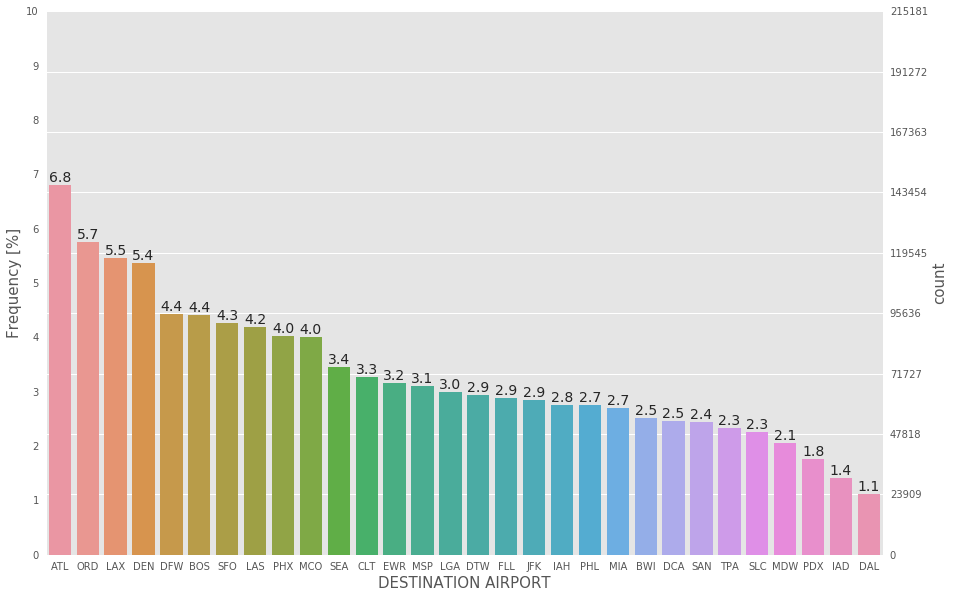

In [27]:
fig = plt.figure(figsize=(15,10));
ax = sns.countplot(x='DEST', data=ontime_df,
              order = ontime_df['DEST'].value_counts().index);
make_twin_axis(ax, ncount, 10)
ax.set_xlabel('DESTINATION AIRPORT');
#fig.savefig('ProjectPortfolio.png', bbox_inches='tight')

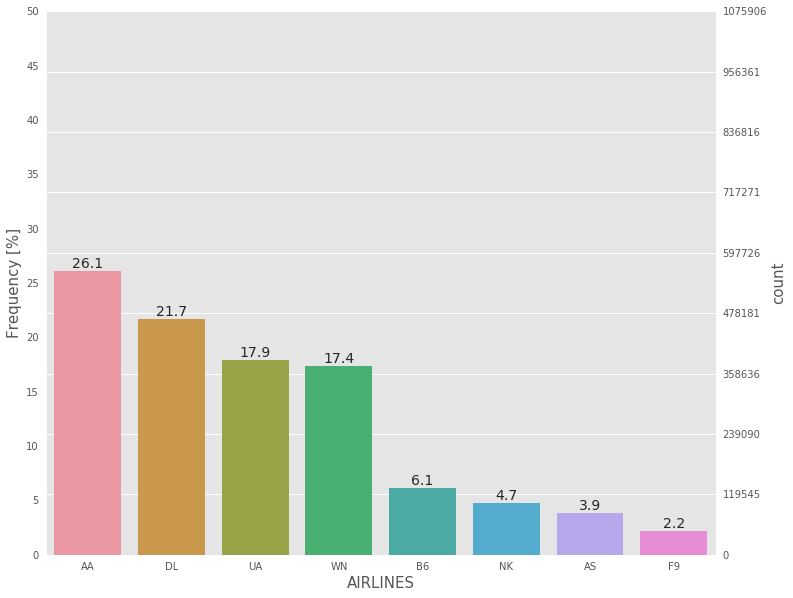

In [28]:
fig = plt.figure(figsize=(12,10));

ax = sns.countplot(x='UNIQUE_CARRIER', data=ontime_df,
              order = ontime_df['UNIQUE_CARRIER'].value_counts().index);
make_twin_axis(ax, ncount, 50)
ax.set_xlabel('AIRLINES');

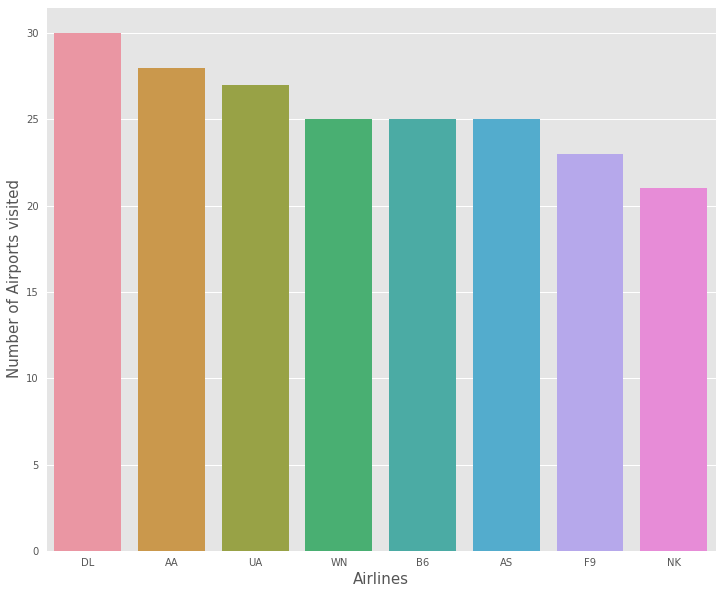

In [29]:
fig = plt.figure(figsize=(12,10));

flight_airport = ontime_df.groupby(['UNIQUE_CARRIER'])['DEST'].agg('nunique')
flight_airport.index = flight_airport.index.astype('str')
flight_airport.sort_values(ascending=False, inplace=True)
ax = sns.barplot(x=flight_airport.index, y=flight_airport.values); #, order=flight_airport.values().index);
ax.set_xlabel('Airlines');
ax.set_ylabel('Number of Airports visited');

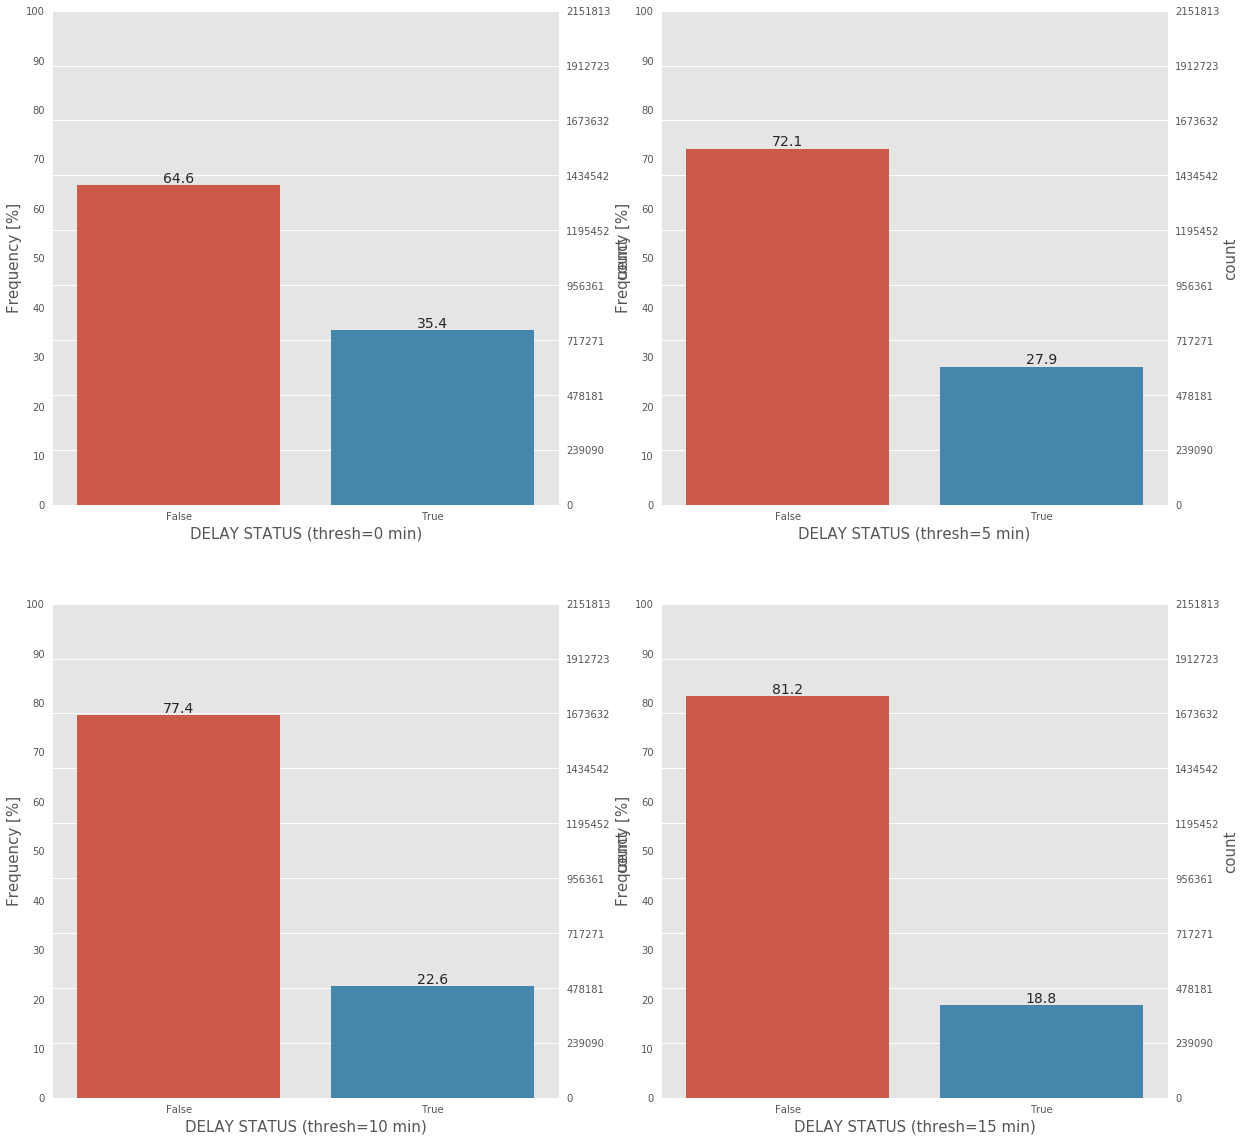

In [30]:
#fig = plt.figure(figsize=(6,6));
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,20))
                                        
sns.countplot(ontime_df['IS_DELAYED_ARR_0'],  ax=ax1[0]);
sns.countplot(ontime_df['IS_DELAYED_ARR_5'],  ax=ax1[1]);
sns.countplot(ontime_df['IS_DELAYED_ARR_10'], ax=ax2[0]);
sns.countplot(ontime_df['IS_DELAYED_ARR_15'], ax=ax2[1]);

make_twin_axis(ax1[0], ncount)
make_twin_axis(ax1[1], ncount)
make_twin_axis(ax2[0], ncount)
make_twin_axis(ax2[1], ncount)

ax1[0].set_xlabel('DELAY STATUS (thresh=0 min)');
ax1[1].set_xlabel('DELAY STATUS (thresh=5 min)');
ax2[0].set_xlabel('DELAY STATUS (thresh=10 min)');
ax2[1].set_xlabel('DELAY STATUS (thresh=15 min)');

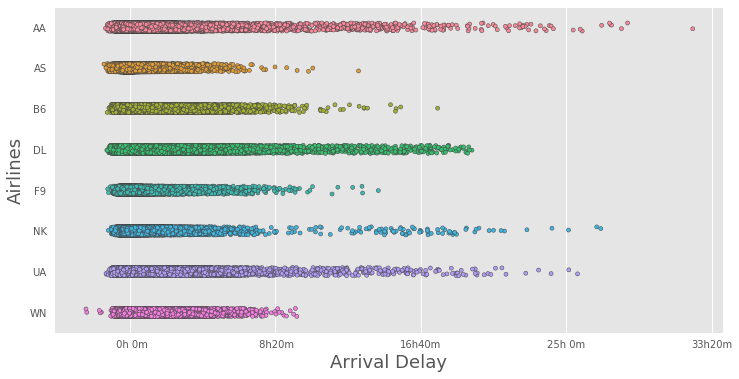

In [31]:
fig = plt.figure(figsize=(12,6));
ax3 = sns.stripplot(y="UNIQUE_CARRIER", x="ARR_DELAY", size = 4, 
                    data=ontime_df, linewidth = 0.5,  jitter=True)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival Delay', fontsize=18);
plt.ylabel('Airlines', fontsize=18);

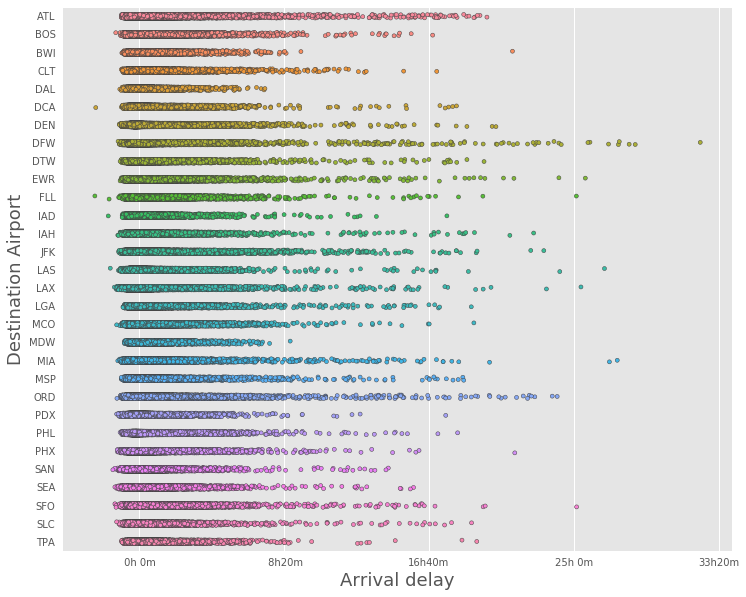

In [32]:
fig = plt.figure(figsize=(12,10));
ax3 = sns.stripplot(y="DEST", x="ARR_DELAY", size = 4, 
                    data=ontime_df, linewidth = 0.5,  jitter=True)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Arrival delay', fontsize=18);
plt.ylabel('Destination Airport', fontsize=18);

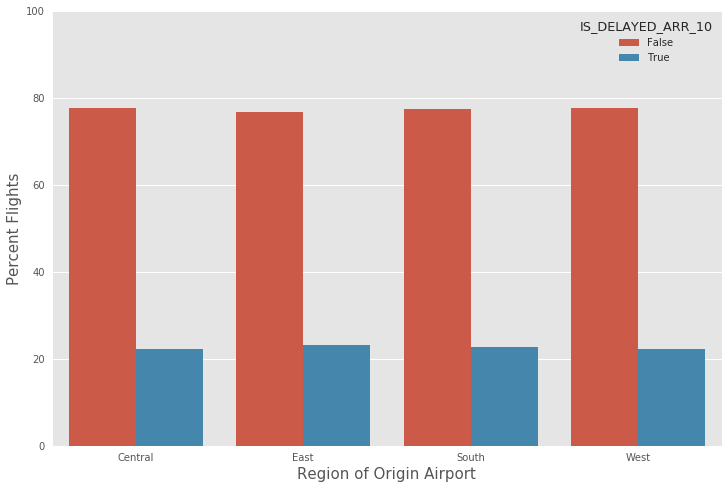

In [33]:
fig = plt.figure(figsize=(12,8));
region_counts = (ontime_df.groupby(['ORIG_REGION'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="ORIG_REGION", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=region_counts);
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('Region of Origin Airport');

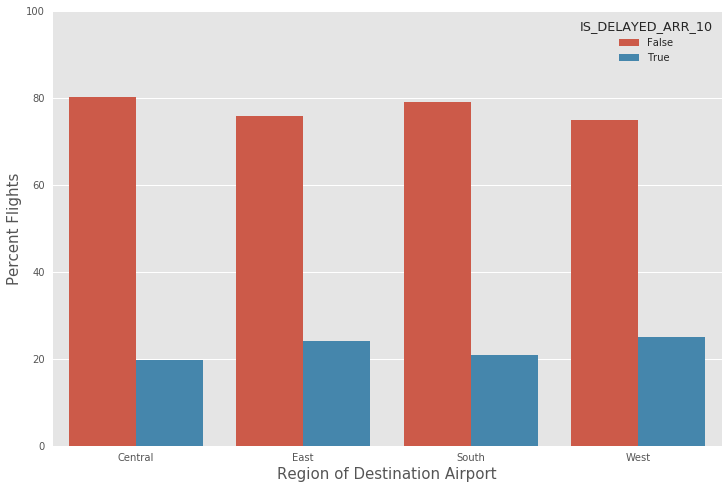

In [34]:
fig = plt.figure(figsize=(12,8));
region_counts = (ontime_df.groupby(['DEST_REGION'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="DEST_REGION", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=region_counts);
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('Region of Destination Airport');

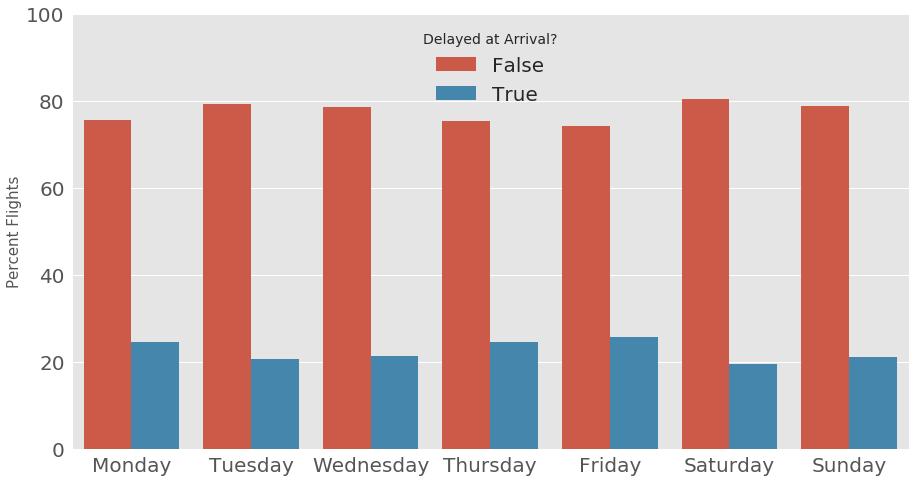

In [19]:
fig = plt.figure(figsize=(15,8));
dow_counts = (ontime_df.groupby(['DAY_OF_WEEK'])['IS_DELAYED_ARR_10']
                       .value_counts(normalize=True)
                       .rename('percentage')
                       .mul(100)
                       .reset_index())
                     
ax = sns.barplot(x="DAY_OF_WEEK", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=dow_counts,
                 order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('');
l = ax.legend()
l.set_title('Delayed at Arrival?')
fig.savefig('day_of_week_delays.png', bbox_inches='tight')

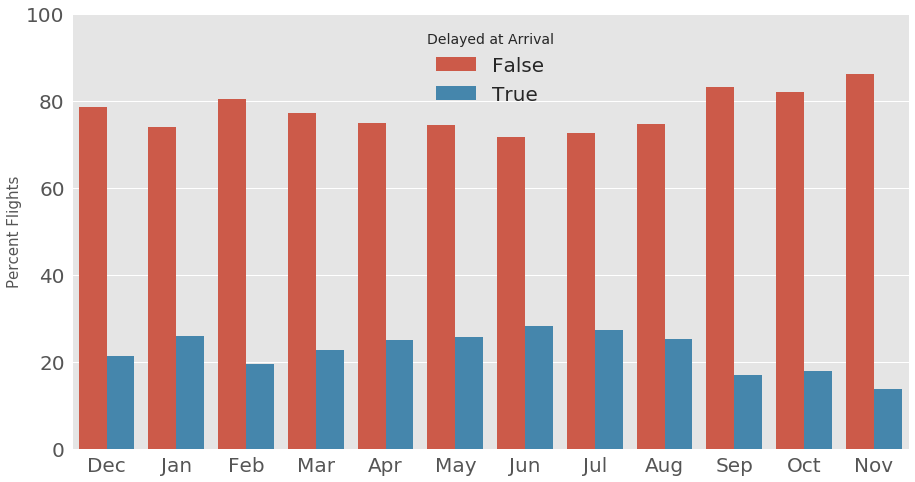

In [18]:
fig = plt.figure(figsize=(15,8));
month_counts = (ontime_df.groupby(['MONTH'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="MONTH", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=month_counts, 
                 order=['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']);
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('');
l = ax.legend()
l.set_title('Delayed at Arrival?')

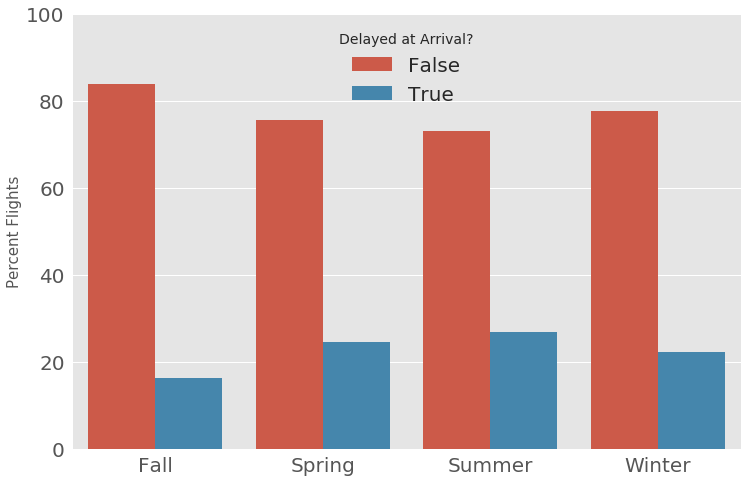

In [20]:
fig = plt.figure(figsize=(12,8));
season_counts = (ontime_df.groupby(['SEASON'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="SEASON", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=season_counts);
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('');
l = ax.legend()
l.set_title('Delayed at Arrival?')
fig.savefig('season_delays.png', bbox_inches='tight')

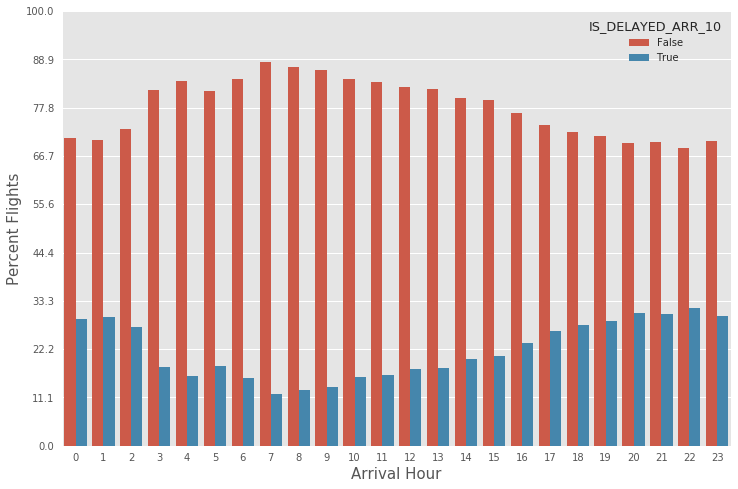

In [38]:
fig = plt.figure(figsize=(12,8));
arrtimeall_counts = (ontime_df.groupby(['ARR_HOUR'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="ARR_HOUR", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=arrtimeall_counts)
ax.set_ylim(0,100);
ax.yaxis.set_major_locator(ticker.LinearLocator(10))
ax.set_xlabel('Arrival Hour');
ax.set_ylabel('Percent Flights');

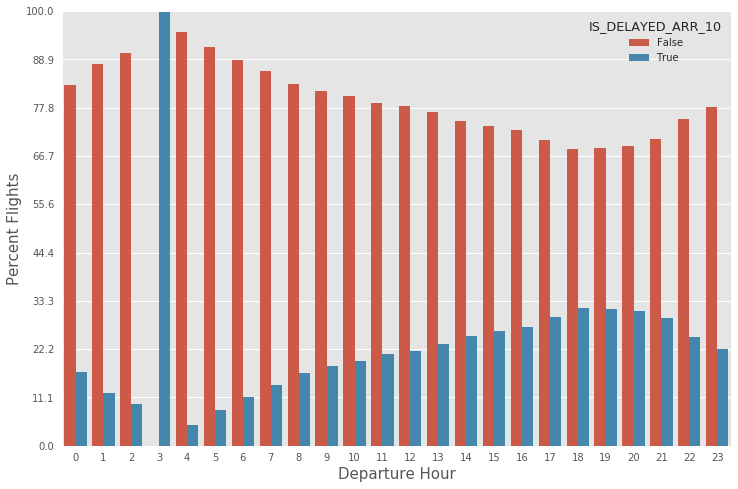

In [39]:
fig = plt.figure(figsize=(12,8));
deptimeall_counts = (ontime_df.groupby(['DEP_HOUR'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="DEP_HOUR", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=deptimeall_counts)
ax.set_ylim(0,100);
ax.yaxis.set_major_locator(ticker.LinearLocator(10))
ax.set_xlabel('Departure Hour');
ax.set_ylabel('Percent Flights');

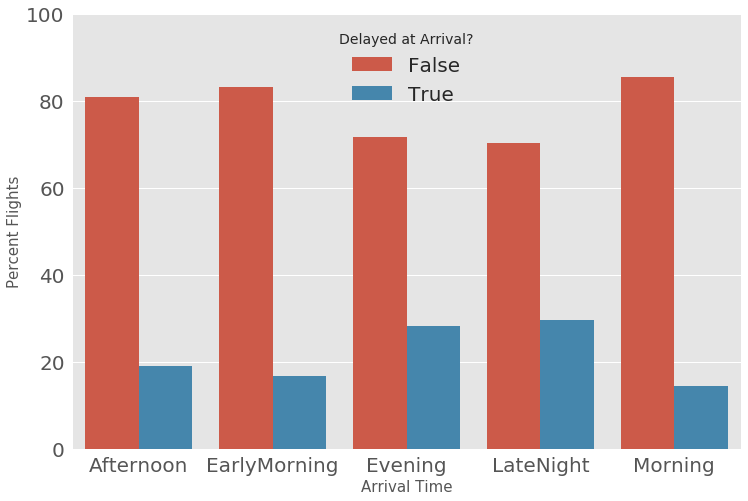

In [21]:
fig = plt.figure(figsize=(12,8));
arrtime_counts = (ontime_df.groupby(['ARR_TIME_BIN'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="ARR_TIME_BIN", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=arrtime_counts)
ax.set_ylim(0,100);
ax.set_xlabel('Arrival Time');
ax.set_ylabel('Percent Flights');
l = ax.legend()
l.set_title('Delayed at Arrival?')
fig.savefig('arrival_time_delays.png', bbox_inches='tight')

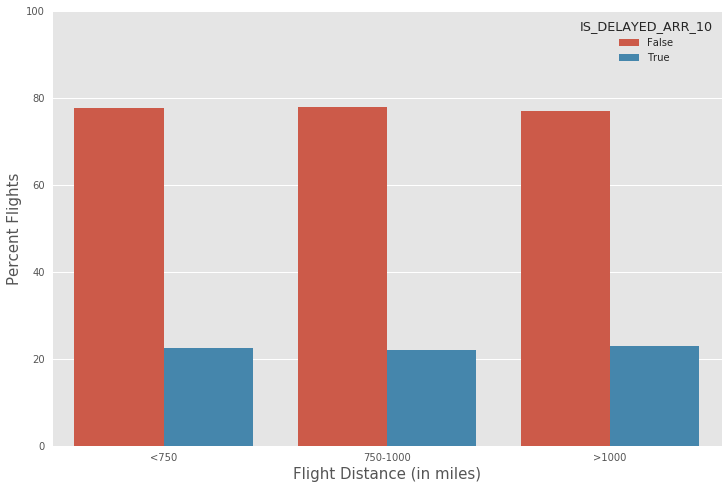

In [41]:
fig = plt.figure(figsize=(12,8));
distance_counts = (ontime_df.groupby(['DISTANCE_BIN'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="DISTANCE_BIN", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=distance_counts)
ax.set_ylim(0,100);
ax.set_xlabel('Flight Distance (in miles)');
ax.set_ylabel('Percent Flights');
ax.set_xticklabels(['<750', '750-1000', '>1000']);

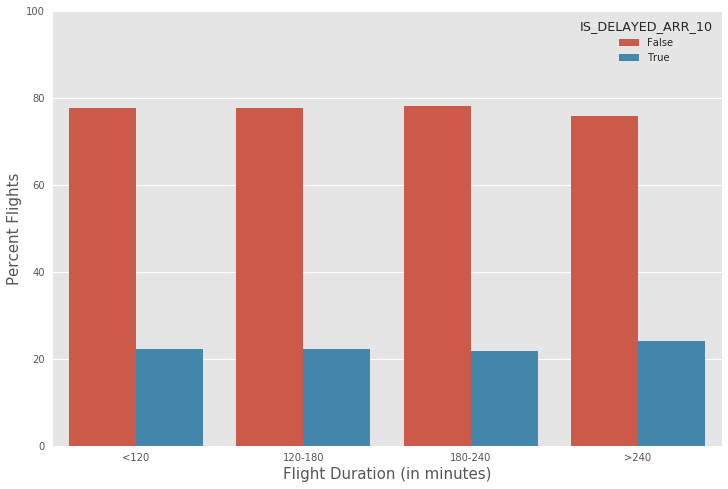

In [42]:
fig = plt.figure(figsize=(12,8));
duration_counts = (ontime_df.groupby(['DURATION_BIN'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="DURATION_BIN", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=duration_counts)
ax.set_ylim(0,100);
ax.set_xlabel('Flight Duration (in minutes)');
ax.set_ylabel('Percent Flights');
ax.set_xticklabels(['<120', '120-180', '180-240', '>240']);

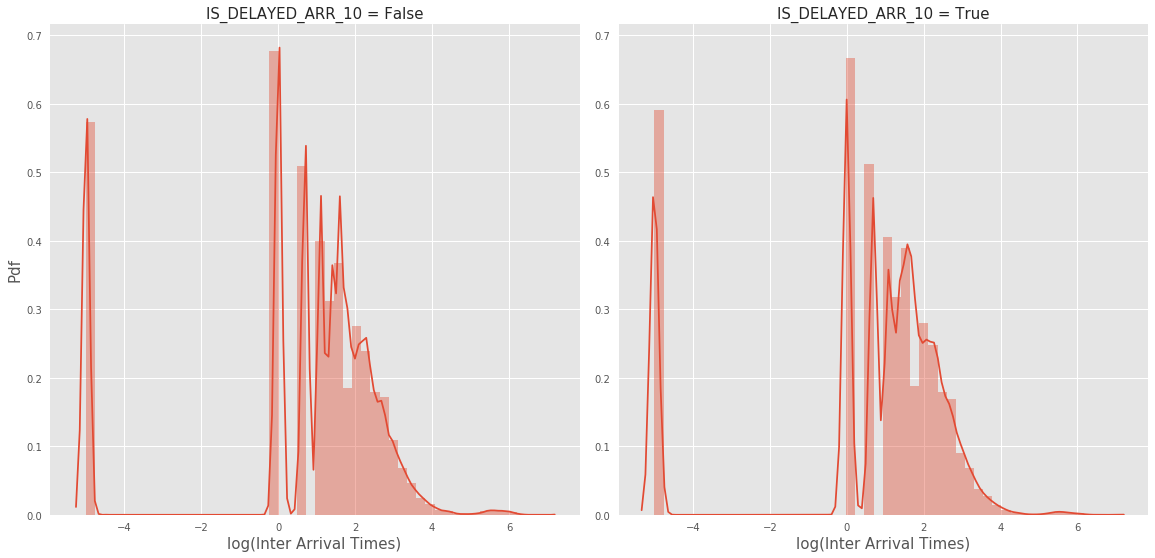

In [43]:
g = sns.FacetGrid(ontime_df, col="IS_DELAYED_ARR_10", size=8);
g = (g.map(sns.distplot, "LOG_INTER_ARR_TIME")
     .set_axis_labels("log(Inter Arrival Times)", "Pdf"));
#plt.xlabel('log(Inter Arrival Times)');

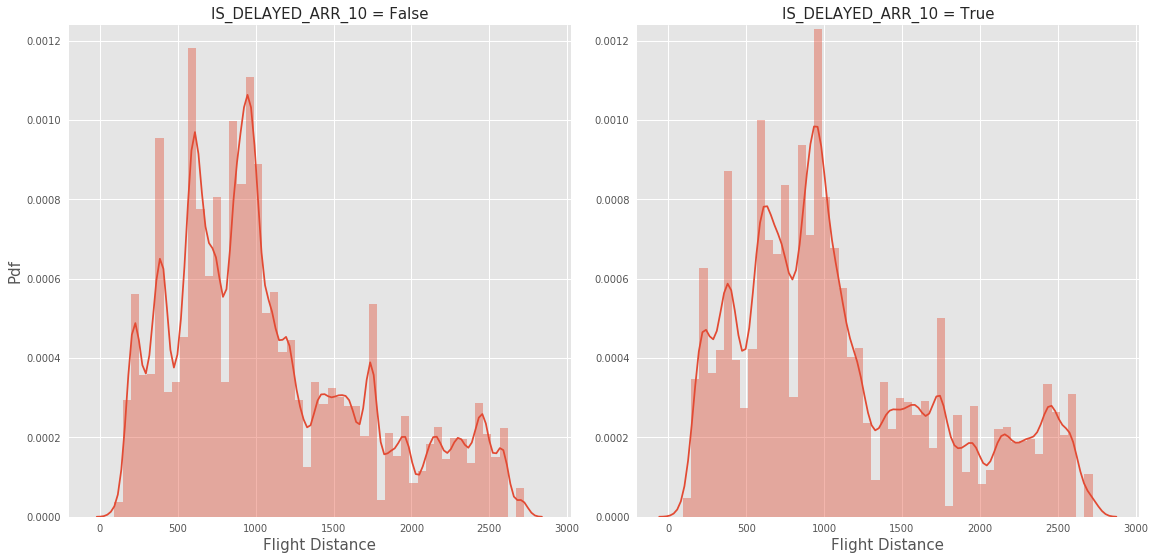

In [34]:
g = sns.FacetGrid(ontime_df, col="IS_DELAYED_ARR_10", size=8);
g = (g.map(sns.distplot, "DISTANCE")
     .set_axis_labels("Flight Distance", "Pdf"));

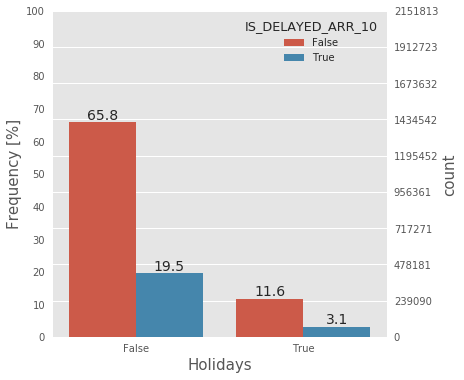

In [44]:
fig = plt.figure(figsize=(6,6));
ax = sns.countplot(x='HOLIDAY', hue='IS_DELAYED_ARR_10',
                   data=ontime_df);
make_twin_axis(ax, ncount)
ax.set_xlabel('Holidays');

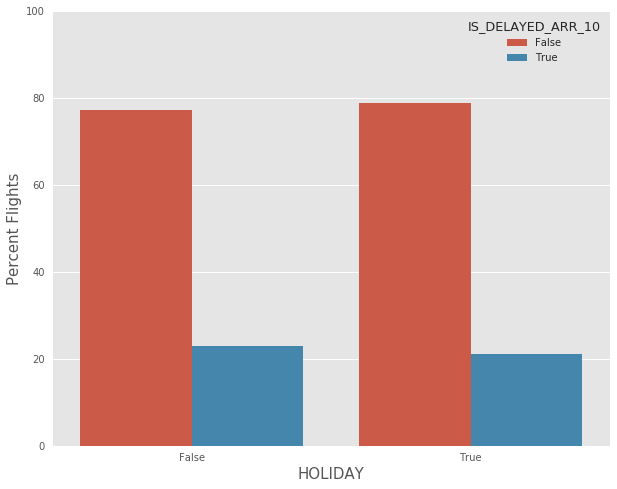

In [45]:
fig = plt.figure(figsize=(10,8));
holiday_counts = (ontime_df.groupby(['HOLIDAY'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="HOLIDAY", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=holiday_counts)
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');

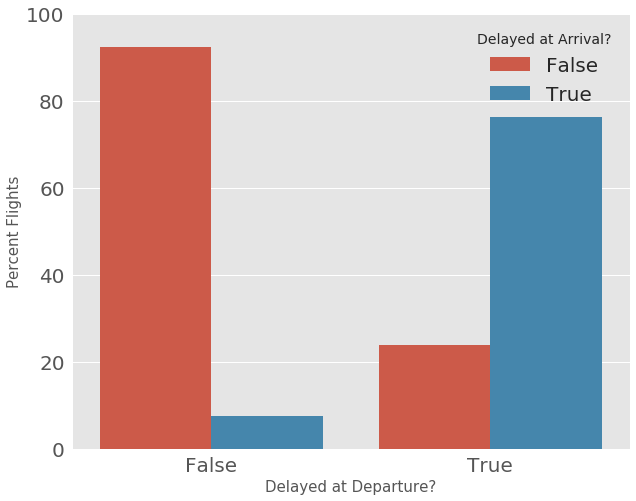

In [22]:
fig = plt.figure(figsize=(10,8));
depdelay_counts = (ontime_df.groupby(['IS_DELAYED_DEP_10'])['IS_DELAYED_ARR_10']
                          .value_counts(normalize=True)
                          .rename('percentage')
                          .mul(100)
                          .reset_index())
                     
ax = sns.barplot(x="IS_DELAYED_DEP_10", y="percentage", 
                 hue='IS_DELAYED_ARR_10', data=depdelay_counts)
ax.set_ylim(0,100);
ax.set_ylabel('Percent Flights');
ax.set_xlabel('Delayed at Departure?');
l = ax.legend()
l.set_title('Delayed at Arrival?')
fig.savefig('arr_dep_delays.png', bbox_inches='tight')

# Cross Validation/ Holdout Split

In [10]:
print(features)

['ORIGIN', 'DEST', 'ORIG_REGION', 'DEST_REGION', 'INTER_ARR_TIME', 'LOG_INTER_ARR_TIME', 'UNIQUE_CARRIER', 'FL_NUM', 'DISTANCE', 'DISTANCE_BIN', 'DURATION_BIN', 'DEP_DELAY_GROUP', 'IS_DELAYED_DEP_0', 'IS_DELAYED_DEP_5', 'IS_DELAYED_DEP_10', 'IS_DELAYED_DEP_15', 'HOLIDAY', 'DAY_OF_WEEK', 'DEP_HOUR', 'ARR_HOUR', 'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'MONTH']


In [8]:
features_select = ['ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'DISTANCE', 
                   'DAY_OF_WEEK', 'DEP_TIME_BIN', 'ARR_TIME_BIN', 
                   'SEASON', 'HOLIDAY', 'LOG_INTER_ARR_TIME',
                   'ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
                   'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW',
                   'IS_DELAYED_DEP_10']
target_select = ['IS_DELAYED_ARR_10']
X, y = ontime_df[features_select], ontime_df[target_select]

X_cross_val, X_holdout, y_cross_val, y_holdout = train_test_split(X, y, test_size=0.3, 
                                                                  random_state=0, stratify=y)
y_cross_val = np.ravel(y_cross_val)
y_holdout = np.ravel(y_holdout)

In [9]:
[X_cross_val.shape, y_cross_val.shape]

[(1506269, 17), (1506269,)]

In [10]:
[X_holdout.shape, y_holdout.shape]

[(645544, 17), (645544,)]

# Categorical Feature Representation

In [14]:
category_cols = list(X_cross_val.select_dtypes(include=['category'])
                     .columns.values)
category_cols

['ORIGIN',
 'DEST',
 'UNIQUE_CARRIER',
 'DAY_OF_WEEK',
 'DEP_TIME_BIN',
 'ARR_TIME_BIN',
 'SEASON']

## 1. Dummy columns

In [11]:
X_CV_dummy = create_category_as_dummy(X_cross_val)
X_CV_dummy.columns.size

99

In [16]:
X_CV_dummy.columns

Index(['DISTANCE', 'HOLIDAY', 'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP',
       'ORIG_SNOW', 'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW', 'IS_DELAYED_DEP_10',
       'ORIGIN_ATL', 'ORIGIN_BOS', 'ORIGIN_BWI', 'ORIGIN_CLT', 'ORIGIN_DAL',
       'ORIGIN_DCA', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_DTW', 'ORIGIN_EWR',
       'ORIGIN_FLL', 'ORIGIN_IAD', 'ORIGIN_IAH', 'ORIGIN_JFK', 'ORIGIN_LAS',
       'ORIGIN_LAX', 'ORIGIN_LGA', 'ORIGIN_MCO', 'ORIGIN_MDW', 'ORIGIN_MIA',
       'ORIGIN_MSP', 'ORIGIN_ORD', 'ORIGIN_PDX', 'ORIGIN_PHL', 'ORIGIN_PHX',
       'ORIGIN_SAN', 'ORIGIN_SEA', 'ORIGIN_SFO', 'ORIGIN_SLC', 'ORIGIN_TPA',
       'DEST_ATL', 'DEST_BOS', 'DEST_BWI', 'DEST_CLT', 'DEST_DAL', 'DEST_DCA',
       'DEST_DEN', 'DEST_DFW', 'DEST_DTW', 'DEST_EWR', 'DEST_FLL', 'DEST_IAD',
       'DEST_IAH', 'DEST_JFK', 'DEST_LAS', 'DEST_LAX', 'DEST_LGA', 'DEST_MCO',
       'DEST_MDW', 'DEST_MIA', 'DEST_MSP', 'DEST_ORD', 'DEST_PDX', 'DEST_PHL',
       'DEST_PHX', 'DEST_SAN', 'DEST_SEA', 'DEST_SFO', 'DEST_SLC

In [12]:
X_train_dummy, X_validate_dummy, y_train_dummy, y_validate_dummy = \
            train_test_split(X_CV_dummy, y_cross_val, 
                             test_size=0.3, random_state=0, 
                             stratify=y_cross_val)

## 2. Numerical Labels

In [13]:
X_CV_label = create_category_as_labels(X_cross_val)
X_CV_label.columns.size

17

In [19]:
X_CV_label.columns

Index(['ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'DISTANCE', 'DAY_OF_WEEK',
       'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'HOLIDAY',
       'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
       'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW', 'IS_DELAYED_DEP_10'],
      dtype='object')

In [14]:
X_train_label, X_validate_label, y_train_label, y_validate_label = \
            train_test_split(X_CV_label, y_cross_val, 
                             test_size=0.3, random_state=0, 
                             stratify=y_cross_val)

## 3. Frequency

# Define Classifiers and Metrics

In [22]:
def batch_classify(X_train, Y_train, \
                   X_test, Y_test, \
                   dict_classifiers, verbose=True):
    
    num_classifiers = len(dict_classifiers.keys())
    if verbose:
        print('Cross-validating with {} models..'.format(num_classifiers))
    
    df_results = pd.DataFrame(data=np.zeros(shape=(num_classifiers,14)), 
                              columns = ['classifier', 'training_time',
                                         'accuracy_train', 'accuracy_test',
                                         'precision_train', 'precision_test',
                                         'recall_train', 'recall_test',
                                         'F1_train', 'F1_test',
                                         'Fb_train', 'Fb_test',
                                         'AUC_train', 'AUC_test'])
    
    count = 0
    for key, classifier in dict_classifiers.items():
        if verbose:
            print('Working on {} model..'.format(key))
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred  = classifier.predict(X_test)
        
        train_score = classifier.score(X_train, Y_train)
        test_score  = classifier.score(X_test, Y_test)
        
        df_results.loc[count,'classifier']      = key
        df_results.loc[count,'training_time']   = t_diff
        df_results.loc[count,'accuracy_train']  = train_score
        df_results.loc[count,'accuracy_test']   = test_score
        df_results.loc[count,'precision_train'] = precision_score(Y_train, Y_train_pred)
        df_results.loc[count,'precision_test']  = precision_score(Y_test, Y_test_pred)
        df_results.loc[count,'recall_train']    = recall_score(Y_train, Y_train_pred)
        df_results.loc[count,'recall_test']     = recall_score(Y_test, Y_test_pred)
        df_results.loc[count,'F1_train']        = f1_score(Y_train, Y_train_pred)
        df_results.loc[count,'F1_test']         = f1_score(Y_test, Y_test_pred)
        df_results.loc[count,'Fb_train']        = fbeta_score(Y_train, Y_train_pred, beta=2)
        df_results.loc[count,'Fb_test']         = fbeta_score(Y_test, Y_test_pred, beta=2)
        df_results.loc[count,'AUC_train']       = roc_auc_score(Y_train, classifier.predict_proba(X_train)[:,1])
        df_results.loc[count,'AUC_test']        = roc_auc_score(Y_test, classifier.predict_proba(X_test)[:,1])
        
        if verbose:
            print("\ttrained {c} in {f:.2f} s".format(c=key, f=t_diff))
            
        count+=1
        
    return df_results

In [23]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(C=1e6),
#    "Logistic Regression Regularized": LogisticRegression(),
    "Logistic Regression Balanced" : LogisticRegression(C=1e6, class_weight='balanced'),
    "Logistic Regression 4X" : LogisticRegression(C=1e6, class_weight={1 : 4, 0 : 1}),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(min_samples_leaf=50,
                                            max_features=0.5,
                                            class_weight='balanced'),
    "Random Forest 100 trees": RandomForestClassifier(n_estimators=100,
                                                      max_features=0.5,
                                                      min_samples_leaf=50,
                                                      class_weight='balanced',
                                                      oob_score = True,
                                                      n_jobs = -1)
}
#    "Random Forest 200 trees": RandomForestClassifier(n_estimators=200,
#                                                      max_features=0.5,
#                                                      min_samples_leaf=50, 
#                                                      class_weight='balanced',
#                                                      oob_score = True,
#                                                      n_jobs = -1)
#}

# Classification

## A. No Departure delay and No Weather information

In [52]:
drop_features =    ['ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
                   'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW',
                   'IS_DELAYED_DEP_10']

### Using dummy 

In [53]:
X_train_dummy_A    = X_train_dummy.drop(drop_features, axis=1)
X_validate_dummy_A = X_validate_dummy.drop(drop_features, axis=1)
X_train_dummy_A.columns

Index(['DISTANCE', 'HOLIDAY', 'LOG_INTER_ARR_TIME', 'ORIGIN_ATL', 'ORIGIN_BOS',
       'ORIGIN_BWI', 'ORIGIN_CLT', 'ORIGIN_DAL', 'ORIGIN_DCA', 'ORIGIN_DEN',
       'ORIGIN_DFW', 'ORIGIN_DTW', 'ORIGIN_EWR', 'ORIGIN_FLL', 'ORIGIN_IAD',
       'ORIGIN_IAH', 'ORIGIN_JFK', 'ORIGIN_LAS', 'ORIGIN_LAX', 'ORIGIN_LGA',
       'ORIGIN_MCO', 'ORIGIN_MDW', 'ORIGIN_MIA', 'ORIGIN_MSP', 'ORIGIN_ORD',
       'ORIGIN_PDX', 'ORIGIN_PHL', 'ORIGIN_PHX', 'ORIGIN_SAN', 'ORIGIN_SEA',
       'ORIGIN_SFO', 'ORIGIN_SLC', 'ORIGIN_TPA', 'DEST_ATL', 'DEST_BOS',
       'DEST_BWI', 'DEST_CLT', 'DEST_DAL', 'DEST_DCA', 'DEST_DEN', 'DEST_DFW',
       'DEST_DTW', 'DEST_EWR', 'DEST_FLL', 'DEST_IAD', 'DEST_IAH', 'DEST_JFK',
       'DEST_LAS', 'DEST_LAX', 'DEST_LGA', 'DEST_MCO', 'DEST_MDW', 'DEST_MIA',
       'DEST_MSP', 'DEST_ORD', 'DEST_PDX', 'DEST_PHL', 'DEST_PHX', 'DEST_SAN',
       'DEST_SEA', 'DEST_SFO', 'DEST_SLC', 'DEST_TPA', 'UNIQUE_CARRIER_AA',
       'UNIQUE_CARRIER_AS', 'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL',


In [62]:
[X_train_dummy_A.shape, y_train_dummy.shape]

[(1054388, 92), (1054388,)]

In [63]:
[X_validate_dummy_A.shape, y_validate_dummy.shape]

[(451881, 92), (451881,)]

In [64]:
metrics_dummy_A = batch_classify(X_train_dummy_A, y_train_dummy, 
                               X_validate_dummy_A, y_validate_dummy, 
                               dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..
	trained Logistic Regression in 11.73 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 13.75 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 12.90 s
Working on Naive Bayes model..
	trained Naive Bayes in 6.33 s
Working on Decision Tree model..
	trained Decision Tree in 14.53 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 766.77 s


In [65]:
metrics_dummy_A

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,11.728749,0.774701,0.774492,0.555952,0.542976,0.017630,0.016570,0.034176,0.032159,0.021864,0.020556,0.660737,0.661339
1,Logistic Regression Balanced,13.752547,0.607970,0.608817,0.316882,0.317601,0.634969,0.635660,0.422777,0.423570,0.528806,0.529590,0.661885,0.662835
2,Logistic Regression 4X,12.901931,0.549955,0.550751,0.297132,0.297755,0.725339,0.726508,0.421570,0.422394,0.563052,0.564063,0.661865,0.662826
3,Naive Bayes,6.329564,0.626309,0.626523,0.308586,0.308665,0.526164,0.525756,0.389019,0.388970,0.461136,0.460921,0.624304,0.625388
4,Decision Tree,14.534635,0.654320,0.628044,0.360302,0.329447,0.682016,0.623034,0.471510,0.430993,0.578676,0.528788,0.727621,0.674036
5,Random Forest 100 trees,766.770259,0.685676,0.665330,0.384680,0.357432,0.650783,0.601922,0.483539,0.448523,0.571689,0.529486,0.740161,0.697352


### Using labels

In [54]:
X_train_label_A    = X_train_label.drop(drop_features, axis=1)
X_validate_label_A = X_validate_label.drop(drop_features, axis=1)
X_train_label_A.columns

Index(['ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'DISTANCE', 'DAY_OF_WEEK',
       'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'HOLIDAY',
       'LOG_INTER_ARR_TIME'],
      dtype='object')

In [67]:
metrics_label_A = batch_classify(X_train_label_A, y_train_label, 
                                 X_validate_label_A, y_validate_label, 
                                 dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	trained Logistic Regression in 10.52 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 9.28 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 7.19 s
Working on Naive Bayes model..
	trained Naive Bayes in 0.89 s
Working on Decision Tree model..
	trained Decision Tree in 2.89 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 205.00 s


In [68]:
metrics_label_A

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,10.516100,0.773898,0.773898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.561124,0.562370
1,Logistic Regression Balanced,9.279374,0.540963,0.541727,0.258550,0.258661,0.551592,0.550274,0.352072,0.351905,0.449662,0.449027,0.561109,0.562368
2,Logistic Regression 4X,7.193162,0.404814,0.405589,0.247221,0.247533,0.798242,0.798563,0.377521,0.377921,0.552121,0.552556,0.561065,0.562282
3,Naive Bayes,0.894757,0.773898,0.773898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.609358,0.609111
4,Decision Tree,2.894603,0.649845,0.618895,0.356539,0.321007,0.681781,0.614734,0.468221,0.421771,0.576586,0.519639,0.723529,0.663639
5,Random Forest 100 trees,205.004783,0.685152,0.661617,0.384815,0.353499,0.655653,0.599133,0.484984,0.444648,0.574750,0.526029,0.742090,0.692665


### Using frequency counts

## B. Include weather but No Departure delay information

In [55]:
drop_features = ['IS_DELAYED_DEP_10']

### Using dummy

In [56]:
X_train_dummy_B    = X_train_dummy.drop(drop_features, axis=1)
X_validate_dummy_B = X_validate_dummy.drop(drop_features, axis=1)
X_train_dummy_B.columns

Index(['DISTANCE', 'HOLIDAY', 'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP',
       'ORIG_SNOW', 'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW', 'ORIGIN_ATL',
       'ORIGIN_BOS', 'ORIGIN_BWI', 'ORIGIN_CLT', 'ORIGIN_DAL', 'ORIGIN_DCA',
       'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_DTW', 'ORIGIN_EWR', 'ORIGIN_FLL',
       'ORIGIN_IAD', 'ORIGIN_IAH', 'ORIGIN_JFK', 'ORIGIN_LAS', 'ORIGIN_LAX',
       'ORIGIN_LGA', 'ORIGIN_MCO', 'ORIGIN_MDW', 'ORIGIN_MIA', 'ORIGIN_MSP',
       'ORIGIN_ORD', 'ORIGIN_PDX', 'ORIGIN_PHL', 'ORIGIN_PHX', 'ORIGIN_SAN',
       'ORIGIN_SEA', 'ORIGIN_SFO', 'ORIGIN_SLC', 'ORIGIN_TPA', 'DEST_ATL',
       'DEST_BOS', 'DEST_BWI', 'DEST_CLT', 'DEST_DAL', 'DEST_DCA', 'DEST_DEN',
       'DEST_DFW', 'DEST_DTW', 'DEST_EWR', 'DEST_FLL', 'DEST_IAD', 'DEST_IAH',
       'DEST_JFK', 'DEST_LAS', 'DEST_LAX', 'DEST_LGA', 'DEST_MCO', 'DEST_MDW',
       'DEST_MIA', 'DEST_MSP', 'DEST_ORD', 'DEST_PDX', 'DEST_PHL', 'DEST_PHX',
       'DEST_SAN', 'DEST_SEA', 'DEST_SFO', 'DEST_SLC', 'DEST_TPA',
      

In [71]:
metrics_dummy_B = batch_classify(X_train_dummy_B, y_train_dummy, 
                                 X_validate_dummy_B, y_validate_dummy, 
                                 dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..
	trained Logistic Regression in 15.00 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 18.82 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 16.50 s
Working on Naive Bayes model..
	trained Naive Bayes in 6.75 s
Working on Decision Tree model..
	trained Decision Tree in 16.72 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 904.90 s


In [72]:
metrics_dummy_B

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,14.996093,0.780097,0.779781,0.617656,0.612152,0.071963,0.070999,0.128908,0.127240,0.087408,0.086247,0.689648,0.690602
1,Logistic Regression Balanced,18.817909,0.632745,0.633262,0.336745,0.337448,0.643858,0.645624,0.442209,0.443232,0.544534,0.545912,0.687925,0.688928
2,Logistic Regression 4X,16.496668,0.576501,0.577117,0.312648,0.312949,0.728459,0.728054,0.437518,0.437739,0.575406,0.575406,0.687416,0.688441
3,Naive Bayes,6.754935,0.683012,0.682996,0.337337,0.337408,0.416810,0.417154,0.372886,0.373067,0.398054,0.398325,0.635693,0.636966
4,Decision Tree,16.723703,0.690064,0.654947,0.396326,0.352931,0.708711,0.631255,0.508364,0.452739,0.612203,0.545257,0.770651,0.700087
5,Random Forest 100 trees,904.899046,0.733023,0.707487,0.441139,0.403609,0.677444,0.614940,0.534332,0.487351,0.611890,0.556647,0.794847,0.738105


### Using labels

In [57]:
X_train_label_B    = X_train_label.drop(drop_features, axis=1)
X_validate_label_B = X_validate_label.drop(drop_features, axis=1)
X_train_label_B.columns

Index(['ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'DISTANCE', 'DAY_OF_WEEK',
       'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'HOLIDAY',
       'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
       'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW'],
      dtype='object')

In [74]:
metrics_label_B = batch_classify(X_train_label_B, y_train_label, 
                                 X_validate_label_B, y_validate_label, 
                                 dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..
	trained Logistic Regression in 16.98 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 16.07 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 14.54 s
Working on Naive Bayes model..
	trained Naive Bayes in 1.31 s
Working on Decision Tree model..
	trained Decision Tree in 6.87 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 334.92 s


In [75]:
metrics_label_B

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,16.984418,0.775767,0.775766,0.590235,0.588581,0.027026,0.027444,0.051686,0.052443,0.033400,0.033910,0.614578,0.616640
1,Logistic Regression Balanced,16.070657,0.600407,0.602353,0.290021,0.291920,0.529906,0.532206,0.374872,0.377034,0.454689,0.456977,0.611811,0.613883
2,Logistic Regression 4X,14.541213,0.481634,0.483194,0.265284,0.266185,0.730485,0.731861,0.389219,0.390383,0.540812,0.542164,0.610998,0.613075
3,Naive Bayes,1.313641,0.775343,0.775224,0.545330,0.540932,0.038427,0.038739,0.071795,0.072300,0.047202,0.047572,0.637170,0.637586
4,Decision Tree,6.873197,0.689227,0.650543,0.395159,0.347158,0.705733,0.619599,0.506638,0.444990,0.609868,0.535543,0.768977,0.692233
5,Random Forest 100 trees,334.920274,0.735622,0.706080,0.444582,0.401239,0.679042,0.609302,0.537350,0.483851,0.614254,0.552049,0.798043,0.735069


### Using frequency

## C. Include weather and Departure delay information

### Using dummy

In [58]:
X_train_dummy_C    = X_train_dummy
X_validate_dummy_C = X_validate_dummy
X_train_dummy_C.columns

Index(['DISTANCE', 'HOLIDAY', 'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP',
       'ORIG_SNOW', 'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW', 'IS_DELAYED_DEP_10',
       'ORIGIN_ATL', 'ORIGIN_BOS', 'ORIGIN_BWI', 'ORIGIN_CLT', 'ORIGIN_DAL',
       'ORIGIN_DCA', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_DTW', 'ORIGIN_EWR',
       'ORIGIN_FLL', 'ORIGIN_IAD', 'ORIGIN_IAH', 'ORIGIN_JFK', 'ORIGIN_LAS',
       'ORIGIN_LAX', 'ORIGIN_LGA', 'ORIGIN_MCO', 'ORIGIN_MDW', 'ORIGIN_MIA',
       'ORIGIN_MSP', 'ORIGIN_ORD', 'ORIGIN_PDX', 'ORIGIN_PHL', 'ORIGIN_PHX',
       'ORIGIN_SAN', 'ORIGIN_SEA', 'ORIGIN_SFO', 'ORIGIN_SLC', 'ORIGIN_TPA',
       'DEST_ATL', 'DEST_BOS', 'DEST_BWI', 'DEST_CLT', 'DEST_DAL', 'DEST_DCA',
       'DEST_DEN', 'DEST_DFW', 'DEST_DTW', 'DEST_EWR', 'DEST_FLL', 'DEST_IAD',
       'DEST_IAH', 'DEST_JFK', 'DEST_LAS', 'DEST_LAX', 'DEST_LGA', 'DEST_MCO',
       'DEST_MDW', 'DEST_MIA', 'DEST_MSP', 'DEST_ORD', 'DEST_PDX', 'DEST_PHL',
       'DEST_PHX', 'DEST_SAN', 'DEST_SEA', 'DEST_SFO', 'DEST_SLC

In [77]:
metrics_dummy_C = batch_classify(X_train_dummy_C, y_train_dummy, 
                                 X_validate_dummy_C, y_validate_dummy, 
                                 dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..
	trained Logistic Regression in 16.14 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 16.81 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 18.32 s
Working on Naive Bayes model..
	trained Naive Bayes in 6.89 s
Working on Decision Tree model..
	trained Decision Tree in 22.63 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 930.43 s


In [78]:
metrics_dummy_C

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,16.142514,0.889092,0.889838,0.762236,0.763078,0.740444,0.743675,0.751182,0.753252,0.744702,0.747476,0.881426,0.882551
1,Logistic Regression Balanced,16.814728,0.888023,0.888743,0.755888,0.756515,0.745511,0.748999,0.750664,0.752738,0.747563,0.750490,0.881098,0.882162
2,Logistic Regression 4X,18.322853,0.886081,0.886716,0.747560,0.748063,0.749131,0.752347,0.748344,0.750199,0.748816,0.751486,0.880764,0.881840
3,Naive Bayes,6.888140,0.785622,0.785959,0.520173,0.520653,0.668493,0.672353,0.585079,0.586858,0.632427,0.635331,0.808291,0.809948
4,Decision Tree,22.631660,0.870839,0.863608,0.679834,0.666115,0.810406,0.795509,0.739400,0.725085,0.780428,0.765759,0.923390,0.887011
5,Random Forest 100 trees,930.429534,0.889648,0.887298,0.747122,0.742405,0.773867,0.768026,0.760259,0.754998,0.768365,0.762761,0.935355,0.903930


### Using labels

In [59]:
X_train_label_C    = X_train_label
X_validate_label_C = X_validate_label
X_train_label_C.columns

Index(['ORIGIN', 'DEST', 'UNIQUE_CARRIER', 'DISTANCE', 'DAY_OF_WEEK',
       'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON', 'HOLIDAY',
       'LOG_INTER_ARR_TIME', 'ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
       'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW', 'IS_DELAYED_DEP_10'],
      dtype='object')

In [80]:
metrics_label_C = batch_classify(X_train_label_C, y_train_label, 
                                 X_validate_label_C, y_validate_label, 
                                 dict_classifiers, verbose = True)

Cross-validating with 6 models..
Working on Logistic Regression model..
	trained Logistic Regression in 15.05 s
Working on Logistic Regression Balanced model..
	trained Logistic Regression Balanced in 16.34 s
Working on Logistic Regression 4X model..
	trained Logistic Regression 4X in 16.16 s
Working on Naive Bayes model..
	trained Naive Bayes in 1.41 s
Working on Decision Tree model..
	trained Decision Tree in 5.87 s
Working on Random Forest 100 trees model..
	trained Random Forest 100 trees in 316.79 s


In [81]:
metrics_label_C

,classifier,training_time,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,F1_train,F1_test,Fb_train,Fb_test,AUC_train,AUC_test
0,Logistic Regression,15.050210,0.889167,0.889887,0.762080,0.762856,0.741215,0.744399,0.751503,0.753515,0.745296,0.748019,0.868382,0.870130
1,Logistic Regression Balanced,16.336417,0.888928,0.889650,0.760398,0.761133,0.742814,0.746092,0.751503,0.753538,0.746265,0.749053,0.867320,0.869017
2,Logistic Regression 4X,16.163279,0.888766,0.889511,0.759659,0.760473,0.743153,0.746435,0.751316,0.753388,0.746397,0.749201,0.866943,0.868611
3,Naive Bayes,1.405693,0.887161,0.887749,0.752319,0.752620,0.746803,0.750086,0.749551,0.751351,0.747899,0.750591,0.864646,0.866183
4,Decision Tree,5.869084,0.870657,0.862473,0.680331,0.664521,0.807243,0.791154,0.738374,0.722329,0.778209,0.762108,0.922664,0.883528
5,Random Forest 100 trees,316.791112,0.890294,0.888187,0.751665,0.747373,0.768783,0.763583,0.760127,0.755391,0.765297,0.760285,0.936954,0.902850


## Analyzing the best classifiers 

### A. No Departure and Weather Information 

In [50]:
# Models
RFC_A = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_A = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

### Representing categorical features as labels

In [60]:
LR_A.fit(X_train_label_A, y_train_label)

all_coef = np.ravel(np.exp(LR_A.coef_))
index = X_train_label_A.columns.values
pd.Series(all_coef, index=index, name='LR coeff')

ORIGIN                0.996511
DEST                  1.006065
UNIQUE_CARRIER        1.005562
DISTANCE              1.000067
DAY_OF_WEEK           0.969146
DEP_TIME_BIN          0.930756
ARR_TIME_BIN          0.961676
SEASON                1.144140
HOLIDAY               0.863763
LOG_INTER_ARR_TIME    0.992460
Name: LR coeff, dtype: float64

In [61]:
RFC_A.fit(X_train_label_A, y_train_label);

pd.Series(RFC_A.feature_importances_, index=index, name='RF importance')\
         .sort_values(ascending=False)

ARR_TIME_BIN          0.166928
DISTANCE              0.144980
DEST                  0.129441
SEASON                0.115355
ORIGIN                0.104491
UNIQUE_CARRIER        0.088402
DAY_OF_WEEK           0.083282
LOG_INTER_ARR_TIME    0.077575
DEP_TIME_BIN          0.070392
HOLIDAY               0.019154
Name: RF importance, dtype: float64

### Representing categorical features as dummy

In [62]:
LR_A.fit(X_train_dummy_A, y_train_label)

all_coef = np.ravel(np.exp(LR_A.coef_))
index = X_train_dummy_A.columns.values

In [63]:
LR_A_coef = pd.Series(all_coef, index=index, name='LR coeff')
LR_A_coef.nlargest(10)

DEST_SFO                  1.936465
DEST_EWR                  1.927838
ORIGIN_EWR                1.541406
DEST_LAX                  1.488731
ORIGIN_SFO                1.482393
ARR_TIME_BIN_Evening      1.356386
DEST_JFK                  1.330172
DEST_LGA                  1.318777
DEP_TIME_BIN_LateNight    1.317910
DEP_TIME_BIN_Evening      1.309699
Name: LR coeff, dtype: float64

In [64]:
LR_A_coef.nsmallest(10)

DEP_TIME_BIN_EarlyMorning    0.557875
SEASON_Fall                  0.668862
UNIQUE_CARRIER_UA            0.690595
ARR_TIME_BIN_EarlyMorning    0.735245
UNIQUE_CARRIER_DL            0.742970
DEST_MDW                     0.764793
DEST_MSP                     0.777067
ORIGIN_SLC                   0.779348
DEST_BWI                     0.794780
DEST_DTW                     0.799513
Name: LR coeff, dtype: float64

In [65]:
RFC_A.fit(X_train_dummy_A, y_train_label);

RFC_A_imp = pd.Series(RFC_A.feature_importances_, index=index, name='RF importance')\
                     .sort_values(ascending=False)

In [66]:
RFC_A_imp.nlargest(15)

DISTANCE                     0.124957
DEP_TIME_BIN_Evening         0.078391
LOG_INTER_ARR_TIME           0.073179
SEASON_Fall                  0.061246
ARR_TIME_BIN_Evening         0.056270
DEP_TIME_BIN_EarlyMorning    0.032670
DEST_SFO                     0.025615
SEASON_Summer                0.025367
UNIQUE_CARRIER_DL            0.022687
ARR_TIME_BIN_Morning         0.022606
DEST_LAX                     0.022403
UNIQUE_CARRIER_B6            0.020733
DEST_EWR                     0.020462
HOLIDAY                      0.020148
DAY_OF_WEEK_Saturday         0.019229
Name: RF importance, dtype: float64

In [67]:
RFC_A_imp.nsmallest(10)

DEST_DAL                  0.000499
DEST_PDX                  0.000846
ORIGIN_IAD                0.000905
DEST_IAD                  0.000909
DEST_TPA                  0.001044
ORIGIN_DAL                0.001114
ORIGIN_PDX                0.001204
ORIGIN_MDW                0.001261
DEP_TIME_BIN_LateNight    0.001268
DEST_DCA                  0.001361
Name: RF importance, dtype: float64

### B. No Departure and with Weather Information 

In [68]:
# Models
RFC_B = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_B = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

### Representing categorical features as labels

In [69]:
LR_B.fit(X_train_label_B, y_train_label)

all_coef = np.ravel(np.exp(LR_B.coef_))
index = X_train_label_B.columns.values
pd.Series(all_coef, index=index)

ORIGIN                0.997937
DEST                  1.007639
UNIQUE_CARRIER        1.009109
DISTANCE              1.000063
DAY_OF_WEEK           0.970194
DEP_TIME_BIN          0.929741
ARR_TIME_BIN          0.958253
SEASON                1.136816
HOLIDAY               0.909841
LOG_INTER_ARR_TIME    0.991188
ORIG_AWND             1.026829
ORIG_PRCP             1.587201
ORIG_SNOW             1.191220
DEST_AWND             1.029982
DEST_PRCP             1.543212
DEST_SNOW             0.950395
dtype: float64

In [70]:
RFC_B.fit(X_train_label_B, y_train_label);

index = X_train_label_B.columns.values
pd.Series(RFC_B.feature_importances_, index=index).sort_values(ascending=False)


ARR_TIME_BIN          0.131245
ORIG_PRCP             0.090406
DEST_PRCP             0.087410
DISTANCE              0.086763
DEST_AWND             0.084074
DEST                  0.083673
ORIG_AWND             0.078793
SEASON                0.070671
ORIGIN                0.062337
UNIQUE_CARRIER        0.060563
DAY_OF_WEEK           0.053835
LOG_INTER_ARR_TIME    0.036648
DEP_TIME_BIN          0.036445
ORIG_SNOW             0.020374
HOLIDAY               0.011986
DEST_SNOW             0.004778
dtype: float64

### Representing categorical features as dummy

In [71]:
LR_B.fit(X_train_dummy_B, y_train_label)

all_coef = np.ravel(np.exp(LR_B.coef_))
index = X_train_dummy_B.columns.values
LR_B_coef = pd.Series(all_coef, index=index, name='LR coeff')

In [72]:
LR_B_coef.nlargest(10)

DEST_SFO                1.861954
DEST_EWR                1.859309
DEST_PRCP               1.597552
ORIG_PRCP               1.594483
DEST_LAX                1.574520
ORIGIN_EWR              1.466682
ORIGIN_SFO              1.453023
ORIG_SNOW               1.345085
ARR_TIME_BIN_Evening    1.282029
UNIQUE_CARRIER_B6       1.254160
Name: LR coeff, dtype: float64

In [73]:
LR_B_coef.nsmallest(10).sort_values(ascending=False)

ORIGIN_SLC                   0.786593
DEST_DTW                     0.784826
ARR_TIME_BIN_Morning         0.779882
DEST_MSP                     0.764315
DEST_MDW                     0.741720
UNIQUE_CARRIER_DL            0.713090
ARR_TIME_BIN_EarlyMorning    0.703852
UNIQUE_CARRIER_UA            0.664664
SEASON_Fall                  0.660136
DEP_TIME_BIN_EarlyMorning    0.525544
Name: LR coeff, dtype: float64

In [74]:
RFC_B.fit(X_train_dummy_B, y_train_label);

RFC_B_imp = pd.Series(RFC_B.feature_importances_, index=index, name='RF importance')\
                     .sort_values(ascending=False)

In [75]:
RFC_B_imp.nlargest(15)

ORIG_PRCP                    0.088052
DEST_PRCP                    0.087173
DEST_AWND                    0.082035
ORIG_AWND                    0.079602
DISTANCE                     0.079043
DEP_TIME_BIN_Evening         0.056194
ARR_TIME_BIN_Evening         0.041965
LOG_INTER_ARR_TIME           0.037630
SEASON_Fall                  0.036567
DEP_TIME_BIN_EarlyMorning    0.022141
ORIG_SNOW                    0.021479
UNIQUE_CARRIER_DL            0.020368
DEST_SFO                     0.019138
ARR_TIME_BIN_Morning         0.018337
DEST_LAX                     0.017867
Name: RF importance, dtype: float64

In [78]:
RFC_B_imp.nsmallest(15).sort_values(ascending=False)

DEST_MIA      0.000689
DEST_PHL      0.000686
DEST_IAH      0.000667
ORIGIN_PDX    0.000605
DEST_FLL      0.000582
DEST_BWI      0.000539
ORIGIN_DCA    0.000527
ORIGIN_DAL    0.000522
DEST_SLC      0.000458
DEST_PDX      0.000414
ORIGIN_IAD    0.000365
DEST_TPA      0.000351
DEST_DCA      0.000334
DEST_IAD      0.000306
DEST_DAL      0.000156
Name: RF importance, dtype: float64

### C. With Departure and with Weather Information 

In [77]:
# Models
RFC_C = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_C = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [79]:
LR_C.fit(X_train_label_C, y_train_label);

all_coef = np.ravel(np.exp(LR_C.coef_))
index = X_train_label_C.columns.values
pd.Series(all_coef, index=index)

ORIGIN                 0.998670
DEST                   1.009952
UNIQUE_CARRIER         0.958670
DISTANCE               1.000147
DAY_OF_WEEK            0.985820
DEP_TIME_BIN           0.989137
ARR_TIME_BIN           1.012809
SEASON                 1.111258
HOLIDAY                0.893913
LOG_INTER_ARR_TIME     0.984953
ORIG_AWND              1.025512
ORIG_PRCP              1.188797
ORIG_SNOW              1.171073
DEST_AWND              1.023699
DEST_PRCP              1.463673
DEST_SNOW              0.769435
IS_DELAYED_DEP_10     40.041454
dtype: float64

In [80]:
RFC_C.fit(X_train_label_C, y_train_label);

index = X_train_label_C.columns.values
pd.Series(RFC_C.feature_importances_, index=index).sort_values(ascending=False)


IS_DELAYED_DEP_10     0.807086
DISTANCE              0.022103
DEST_PRCP             0.021162
ARR_TIME_BIN          0.020133
DEST_AWND             0.017409
ORIG_AWND             0.016803
DEST                  0.015460
ORIG_PRCP             0.015066
ORIGIN                0.011505
UNIQUE_CARRIER        0.010578
SEASON                0.009703
DAY_OF_WEEK           0.009186
LOG_INTER_ARR_TIME    0.009161
ORIG_SNOW             0.007128
DEP_TIME_BIN          0.005599
HOLIDAY               0.001351
DEST_SNOW             0.000566
dtype: float64

### Representing categorical features as dummy

In [81]:
LR_C.fit(X_train_dummy_C, y_train_label)

all_coef = np.ravel(np.exp(LR_C.coef_))
index = X_train_dummy_C.columns.values
LR_C_coef = pd.Series(all_coef, index=index, name='LR coeff')

In [82]:
LR_C_coef.nlargest(10)

IS_DELAYED_DEP_10    38.848548
DEST_LAX              1.787068
DEST_SFO              1.703163
DEST_PRCP             1.512448
DEST_EWR              1.416616
ORIGIN_EWR            1.306523
ORIGIN_SFO            1.265845
ORIG_SNOW             1.235020
ORIGIN_JFK            1.217831
ORIGIN_PHL            1.193740
Name: LR coeff, dtype: float64

In [83]:
LR_C_coef.nsmallest(10)

SEASON_Fall                  0.614978
UNIQUE_CARRIER_DL            0.618920
ARR_TIME_BIN_EarlyMorning    0.630065
UNIQUE_CARRIER_UA            0.648135
DAY_OF_WEEK_Saturday         0.710377
DEP_TIME_BIN_EarlyMorning    0.716480
DEST_MDW                     0.725549
ORIGIN_PDX                   0.747444
DEST_BWI                     0.747918
DEST_MSP                     0.756898
Name: LR coeff, dtype: float64

In [84]:
RFC_C.fit(X_train_dummy_C, y_train_label);

In [85]:
index = X_train_dummy_C.columns.values
RFC_C_imp = pd.Series(RFC_C.feature_importances_, index=index, name='RF importance')\
                     .sort_values(ascending=False)

In [86]:
RFC_C_imp.nlargest(10)

IS_DELAYED_DEP_10       0.802839
DEST_PRCP               0.021407
DISTANCE                0.020684
DEST_AWND               0.017473
ORIG_AWND               0.017025
ORIG_PRCP               0.013738
DEP_TIME_BIN_Evening    0.012387
LOG_INTER_ARR_TIME      0.008943
ORIG_SNOW               0.007226
ARR_TIME_BIN_Evening    0.007087
Name: RF importance, dtype: float64

In [87]:
RFC_C_imp.nsmallest(10)

ORIGIN_DAL    0.000070
ORIGIN_IAD    0.000081
DEST_DAL      0.000086
ORIGIN_SLC    0.000091
DEST_TPA      0.000100
DEST_SLC      0.000106
ORIGIN_TPA    0.000106
ORIGIN_MDW    0.000115
ORIGIN_SAN    0.000122
DEST_MDW      0.000127
Name: RF importance, dtype: float64

## Effect of different categories of features

In [35]:
features_select

['ORIGIN',
 'DEST',
 'UNIQUE_CARRIER',
 'DISTANCE',
 'DAY_OF_WEEK',
 'DEP_TIME_BIN',
 'ARR_TIME_BIN',
 'SEASON',
 'HOLIDAY',
 'LOG_INTER_ARR_TIME',
 'ORIG_AWND',
 'ORIG_PRCP',
 'ORIG_SNOW',
 'DEST_AWND',
 'DEST_PRCP',
 'DEST_SNOW',
 'IS_DELAYED_DEP_10']

### Effect of Flight based features

In [15]:
features_flight = ['DISTANCE', 'UNIQUE_CARRIER']
#features_flight = ['DISTANCE']
#for airline in list(X_cross_val['UNIQUE_CARRIER'].astype('str').unique()):
#    features_flight.append('UNIQUE_CARRIER_'+airline)
features_flight

['DISTANCE', 'UNIQUE_CARRIER']

In [16]:
# Models
RF_flight = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_flight = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [17]:
LR_flight_score = np.mean(cross_val_score(LR_flight, 
                        X_CV_label[features_flight], y_cross_val, 
                        cv=10, n_jobs=-1,
                        scoring='f1'))

In [18]:
RF_flight_score = np.mean(cross_val_score(RF_flight, 
                        X_CV_label[features_flight], y_cross_val, 
                        cv=10, n_jobs=-1,
                        scoring='f1'))

In [19]:
[LR_flight_score, RF_flight_score]

[0.36881395725442079, 0.37281895903534129]

## Effect of Airport + Flight based features

In [20]:
features_airport = ['DISTANCE', 'UNIQUE_CARRIER', 'LOG_INTER_ARR_TIME', 'ORIGIN', 'DEST']
features_airport

['DISTANCE', 'UNIQUE_CARRIER', 'LOG_INTER_ARR_TIME', 'ORIGIN', 'DEST']

In [21]:
# Models
RF_airport = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_airport = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [22]:
LR_airport_score = np.mean(cross_val_score( LR_airport, 
                                            X_CV_label[features_airport], y_cross_val, 
                                            cv=5, n_jobs=-1,
                                            scoring='f1'))

In [23]:
RF_airport_score = np.mean(cross_val_score( RF_airport, 
                                            X_CV_label[features_airport], y_cross_val, 
                                            cv=5, n_jobs=-1,
                                            scoring='f1'))

In [24]:
[LR_airport_score, RF_airport_score]

[0.36855593560092414, 0.38447650708874559]

## Effect of Flight, Airport, Time based features

In [25]:
features_time = ['DISTANCE', 'UNIQUE_CARRIER', 'LOG_INTER_ARR_TIME', 'ORIGIN', 'DEST',
                 'DAY_OF_WEEK', 'DEP_TIME_BIN', 'ARR_TIME_BIN', 'SEASON','HOLIDAY',]

In [26]:
# Models
RF_time = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_time = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [27]:
LR_time_score = np.mean(cross_val_score(LR_time, 
                                        X_CV_label[features_time], y_cross_val, 
                                        cv=5, n_jobs=-1,
                                        scoring='f1'))

In [28]:
RF_time_score = np.mean(cross_val_score(RF_time, 
                                        X_CV_label[features_time], y_cross_val, 
                                        cv=5, n_jobs=-1,
                                        scoring='f1'))

In [29]:
[LR_time_score, RF_time_score]

[0.37756040745434827, 0.44550632851077221]

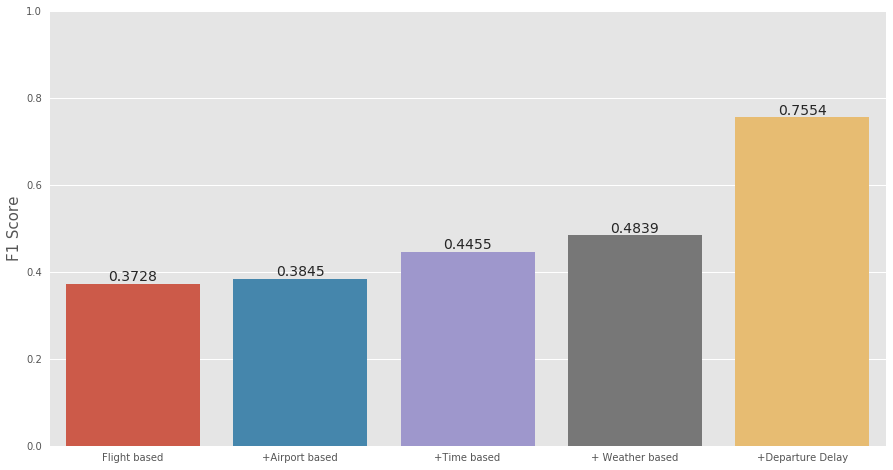

In [49]:
fig = plt.figure(figsize=(15,8));
ax = sns.barplot(x=['Flight based', '+Airport based', '+Time based', '+ Weather based', '+Departure Delay'], 
                 y=[RF_flight_score, RF_airport_score, RF_time_score, 0.483851, 0.755391]);
plt.ylabel('F1 Score', fontsize=25);
ax.set_ylim(0,1);
# Annotate the bars
for p in ax.patches:
    x_bar=p.get_bbox().get_points()[:,0]
    y_bar=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.4f}'.format(y_bar), (x_bar.mean(), y_bar), 
            ha='center', va='bottom') # set the alignment of the text
    
fig.savefig('CrossValidationF1Score.png', bbox_inches='tight')

## Hold out set results

In [30]:
X_HO_label = create_category_as_labels(X_holdout)
X_HO_label.columns.size

17

## A. No weather, No departure delay

In [31]:
# Models
RF_A = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_A = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [32]:
drop_features =    ['ORIG_AWND', 'ORIG_PRCP', 'ORIG_SNOW',
                   'DEST_AWND', 'DEST_PRCP', 'DEST_SNOW',
                   'IS_DELAYED_DEP_10']
X_CV_label_A = X_CV_label.drop(drop_features, axis=1)
X_HO_label_A = X_HO_label.drop(drop_features, axis=1)

LR_A.fit(X_CV_label_A, y_cross_val)
RF_A.fit(X_CV_label_A, y_cross_val)

f1_LR_A    = f1_score(y_holdout, LR_A.predict(X_HO_label_A))
fbeta_LR_A = fbeta_score(y_holdout, LR_A.predict(X_HO_label_A), beta=2)

f1_RF_A    = f1_score(y_holdout, RF_A.predict(X_HO_label_A))
fbeta_RF_A = fbeta_score(y_holdout, RF_A.predict(X_HO_label_A), beta=2)

[f1_LR_A, fbeta_LR_A, f1_RF_A, fbeta_RF_A]

[0.37826443947541794,
 0.55284454896365653,
 0.44817208018342747,
 0.53023969203933718]

## B. With weather, No departure delay

In [33]:
# Models
RF_B = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_B = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [34]:
drop_features =    ['IS_DELAYED_DEP_10']

X_CV_label_B = X_CV_label.drop(drop_features, axis=1)
X_HO_label_B = X_HO_label.drop(drop_features, axis=1)

LR_B.fit(X_CV_label_B, y_cross_val)
RF_B.fit(X_CV_label_B, y_cross_val)

f1_LR_B    = f1_score(y_holdout, LR_B.predict(X_HO_label_B))
fbeta_LR_B = fbeta_score(y_holdout, LR_B.predict(X_HO_label_B), beta=2)

f1_RF_B    = f1_score(y_holdout, RF_B.predict(X_HO_label_B))
fbeta_RF_B = fbeta_score(y_holdout, RF_B.predict(X_HO_label_B), beta=2)

[f1_LR_B, fbeta_LR_B, f1_RF_B, fbeta_RF_B]

[0.38956871563853013,
 0.54128974596466173,
 0.49216976539380919,
 0.5598989932931846]

## C. With weather, with departure delay

In [35]:
# Models
RF_C = RandomForestClassifier(n_estimators=100,
                               max_features=0.5,
                               min_samples_leaf=50,
                               class_weight='balanced',
                               oob_score = True,
                               n_jobs = -1)
LR_C = LogisticRegression(C=1e6, 
                          class_weight={1 : 4, 0 : 1})

In [36]:
X_CV_label_C = X_CV_label
X_HO_label_C = X_HO_label

LR_C.fit(X_CV_label_C, y_cross_val)
RF_C.fit(X_CV_label_C, y_cross_val)

f1_LR_C    = f1_score(y_holdout, LR_C.predict(X_HO_label_C))
fbeta_LR_C = fbeta_score(y_holdout, LR_C.predict(X_HO_label_C), beta=2)

f1_RF_C    = f1_score(y_holdout, RF_C.predict(X_HO_label_C))
fbeta_RF_C = fbeta_score(y_holdout, RF_C.predict(X_HO_label_C), beta=2)

[f1_LR_C, fbeta_LR_C, f1_RF_C, fbeta_RF_C]

[0.74971887272286908,
 0.74522762666255782,
 0.75325951425783366,
 0.75821984057581526]

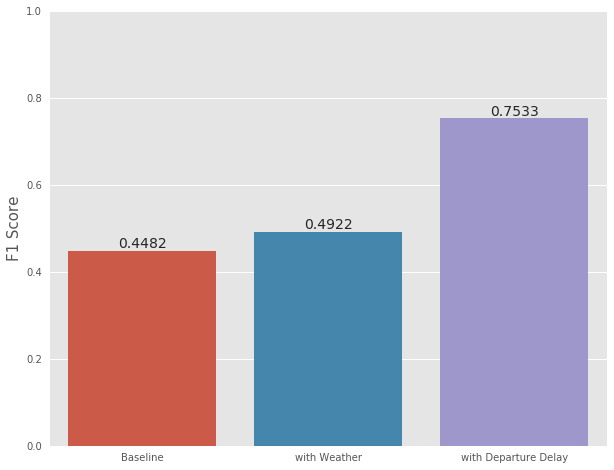

In [45]:
fig = plt.figure(figsize=(10,8));
ax = sns.barplot(x=['Baseline', 'with Weather', 'with Departure Delay'], y=[f1_RF_A, f1_RF_B, f1_RF_C]);
plt.ylabel('F1 Score');
ax.set_ylim(0,1);
# Annotate the bars
for p in ax.patches:
    x_bar=p.get_bbox().get_points()[:,0]
    y_bar=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.4f}'.format(y_bar), (x_bar.mean(), y_bar), 
            ha='center', va='bottom') # set the alignment of the text
    
fig.savefig('HoldoutF1Score.png', bbox_inches='tight')

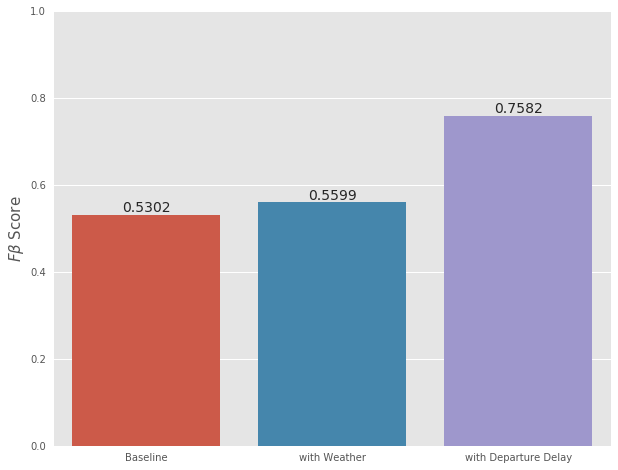

In [44]:
fig = plt.figure(figsize=(10,8));
ax = sns.barplot(x=['Baseline', 'with Weather', 'with Departure Delay'], y=[fbeta_RF_A, fbeta_RF_B, fbeta_RF_C]);
plt.ylabel(r'$F\beta$ Score');
ax.set_ylim(0,1);
# Annotate the bars
for p in ax.patches:
    x_bar=p.get_bbox().get_points()[:,0]
    y_bar=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.4f}'.format(y_bar), (x_bar.mean(), y_bar), 
            ha='center', va='bottom') # set the alignment of the text
    
fig.savefig('HoldoutFbScore.png', bbox_inches='tight')